In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import math
import os
from matplotlib.collections import LineCollection
from copy import deepcopy
import matplotlib.gridspec as gridspec

In [2]:
def get_labels(N, norm_tuple, wt_s=0, resist_s=0.6, rng_to_use=None):
    """Generates N genotype labels, returned as a dataframe with corresponding selection coefficients
    taken from a normal distribution with norm_tuple (mu, sigma)"""
    if rng_to_use is None:
        # Instantiating the default_rng to use later
        rng_to_use = np.random.default_rng()

    # Creating the dataframe
    labels_list = ['Variant_' + str(x) for x in range(1, N+1)]

    labels_df= pd.DataFrame(columns=['Label', 's'])
    labels_df['Label'] = labels_list
    labels_df['s'] = rng_to_use.normal(loc=norm_tuple[0], scale=norm_tuple[1], size=N)

    # Creating the corresponding dictionary
    labels_dict = {labels_df.at[row, 'Label']: labels_df.at[row, 's'] for row in labels_df.index}
    labels_dict.update({'WT': wt_s, 'Resistant': resist_s})

    return labels_df, labels_dict
    

In [3]:
def get_transfo(labels_df, labels_dict, n_clones, wt_freq, lof_rate, rng_to_use=None):
    """Sample cells from the given labels_dict and adds WT to obtain N cells. Then randomly introduces LOF mutations.
    n_clones represents the number of mutant clones initially scraped off the transformations. It is in this smaller population
    that resistant mutations are first introduced. Then, the starting population of size N is obtained by sampling from it"""

    if rng_to_use is None:
        # Instantiating the default_rng to use late
        rng_to_use = np.random.default_rng()

    # Number of clones to sample
    sample_clones = n_clones - (n_clones*wt_freq)

    # Sampling variants
    clones_sampled = rng_to_use.choice(list(labels_df['Label'].unique()), size=int(sample_clones))
    clones_df = pd.DataFrame(columns=['Label', 'Resistant', 's'])
    clones_df['Label'] = clones_sampled
    clones_df['s'] = clones_df['Label'].apply(lambda x: labels_dict[x])

    # Adding the WT cells
    wt_df = pd.DataFrame(columns=['Label', 'Resistant', 's'])
    wt_list = ['WT' for x in range(int(n_clones*wt_freq))]
    wt_df['Label'] = wt_list
    wt_df['s'] = labels_dict['WT']

    clones_df = pd.concat([clones_df, wt_df]).reset_index(drop=True)

    # Randomly introducing resistance mutations
    resist_list = rng_to_use.choice([True, False], size=int(n_clones), replace=True, p=[lof_rate, 1-lof_rate])
    clones_df['Resistant'] = resist_list
    clones_df['s'] = np.where(clones_df['Resistant'], labels_dict['Resistant'], clones_df['s'])
    clones_df['Real_genotype'] = np.where(clones_df['Resistant'], 'Resistant', clones_df['Label'])
    clones_df = clones_df.drop(columns=['Resistant'])

    return clones_df

In [4]:
def get_starting_pop(clones_df, N_starting, rng_to_use=None):

    if rng_to_use is None:
        rng_to_use = np.random.default_rng()
    
    # Sampling N rows randomly with replacement to build the starting population
    index_rand = rng_to_use.choice(list(clones_df.index), size=int(N_starting), replace=True)
    pop_df = clones_df.loc[index_rand, :].copy()

    return pop_df

In [5]:
def pop_to_frequencies(pop_df, label_col, real_label_col):
    pop_in_use = pop_df.copy()
    pop_in_use['Count'] = 1

    if 's' in pop_in_use.columns:
        pop_in_use = pop_in_use.drop(columns='s')

    # Compute the abundance of the real wild-type
    wt_real = pop_in_use[(pop_in_use[label_col] == 'WT') & (pop_in_use[real_label_col] == 'WT')]['Count'].sum()

    # Summing the counts and converting to wt-relative frequencies
    pop_in_use = pop_in_use.groupby(by=[label_col, real_label_col], as_index=False).sum()
    pop_in_use['Count'] = pop_in_use['Count'] / wt_real
    pop_in_use = pop_in_use.rename(columns={'Count': 'WT_rel'})

    return pop_in_use


In [6]:
def sim_passage(init_freq, n_gen, n_passage, n_reads, label_col, real_label_col, s_dict, rng_to_use=None):
    """Computes new wt-relative frequencies after n_gen generations, using the given init_freq initial frequencies
    (dataframe returned by pop_to_frequencies). The initial frequencies for the next passage are returned, after sampling
    n_passage cells to simulate the experimental bottleneck. A sample of n_reads sequencing reads is also returned"""

    if rng_to_use is None:
        rng_to_use = np.random.default_rng()

    # Computing the final frequencies
    freqs_in_use = init_freq.copy()
    freqs_in_use['s'] = freqs_in_use[real_label_col].apply(lambda x: s_dict[x])
    freqs_in_use['Final_WT_rel'] = freqs_in_use['WT_rel'] * np.exp(freqs_in_use['s'] * n_gen)

    # Converting the frequencies to total-relative, for sampling
    freqs_in_use['Final_WT_rel'] = freqs_in_use['Final_WT_rel'] / np.sum(freqs_in_use['Final_WT_rel'])
    freqs_in_use = freqs_in_use.rename(columns={'Final_WT_rel': 'Final_Total_rel'})

    # Generating the sequencing sample
    index_tosamp = rng_to_use.choice(list(freqs_in_use.index), size=int(n_reads), replace=True, p=freqs_in_use['Final_Total_rel'])
    seq_reads = freqs_in_use.loc[index_tosamp, :].copy()
    seq_reads['Count'] = 1
    seq_reads = seq_reads.drop(columns=['Final_Total_rel'])
    seq_reads = seq_reads.groupby(by=[label_col, real_label_col], as_index=False).sum()
    seq_reads = seq_reads.rename(columns={'Count': 'N_reads'})

    # Generating the starting point of the next passage
    index_pop = rng_to_use.choice(list(freqs_in_use.index), size=int(n_passage), replace=True, p=freqs_in_use['Final_Total_rel'])
    pop_next = freqs_in_use.loc[index_pop, :].copy()
    pop_next = pop_next[[label_col, real_label_col]].copy()
    init_next = pop_to_frequencies(pop_next, label_col, real_label_col)

    return init_next, seq_reads
    

### Assembling the functions into a simulation

In [8]:
# What should be the duration of each passage (in reference generations)?
gen_time_screen = pd.read_csv("Gen_time_df.csv")
gen_5FC = gen_time_screen[gen_time_screen['Library'].isin(['L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19'])].drop(columns=['Library']).copy()
med_T1 = np.median(gen_5FC['T1_gen_ref'], axis=0)
med_T2 = np.median(gen_5FC['T2_gen_ref'], axis=0)
med_T3 = np.median(gen_5FC['T3_gen_ref'], axis=0)

duration_T1 = med_T1
duration_T2 = med_T2 - med_T1
duration_T3 = med_T3 - med_T2

print(f'For T0->T1: {duration_T1}')
print(f'For T1->T2: {duration_T2}')
print(f'For T2->T3: {duration_T3}')

For T0->T1: 5.463208107895501
For T1->T2: 4.495305526717824
For T2->T3: 3.5489417171296687


In [9]:
# Defining simulation variables
run_name = 'Normal_005'
current_seed = 32
current_rng = np.random.default_rng(current_seed)

n_variants = 1000
dist_tuple = (0, 0.005)  # According to the standard deviation seen in the median s without 5-FC

transfos_list = ['1', '2', '3', '4']
n_clones = 10000
wt_freq = 0.17  # Frequency seen among sequencing reads, although the expectation was at 11-12%
lof_rate = 0.0012  # From measurements, accounting for the equal mixing of F3 and F4 mutant libraries

replicates_list = ['A', 'B']
starting_pop = 2500000
labels_col = 'Label'
reals_col = 'Real_genotype'

seq_reads = 1000000
gen_dict = {'T0': 0, 'T1': 5.46, 'T2': 4.50, 'T3': 3.55}  # Duration in reference generations, based on the experimental duration of the passages
pop_passage = 2500000

In [10]:
# Model of the df to compile all read counts
df_all_model = pd.DataFrame(columns=['Label', 'Real_genotype', 'Bio_rep', 'Tech_rep', 'Timepoint', 'N_reads'])

# Generating the ground truth Label -> s mapping
genotypes_df, genotypes_dict = get_labels(n_variants, dist_tuple, rng_to_use=current_rng)

In [11]:
# Big loopTM to simulate a screen
df_current_sim = df_all_model.copy()

for bio_rep in transfos_list:  # Generating a new set of clones ('transformation') for each biological replicate
    clones_current = get_transfo(genotypes_df, genotypes_dict, n_clones, wt_freq, lof_rate, rng_to_use=current_rng)

    for tech_rep in replicates_list:  # Sampling independently to generate each technical replicate
        init_pop = get_starting_pop(clones_current, starting_pop, rng_to_use=current_rng)

        # Obtain the initial wt-relative frequencies
        init_freqs = pop_to_frequencies(init_pop, labels_col, reals_col)

        # Sample T0 sequencing reads and add to the df (should definie a new function, which would also be called in sim_passage()
        T0_freqs = init_freqs.copy()
        T0_freqs['Total_rel'] = T0_freqs['WT_rel'] / np.sum(T0_freqs['WT_rel'])
        index_T0 = current_rng.choice(list(T0_freqs.index), size=int(seq_reads), replace=True, p=T0_freqs['Total_rel'])
        T0_reads = T0_freqs.loc[index_T0, :].copy()
        T0_reads['Count'] = 1
        T0_reads = T0_reads.drop(columns=['Total_rel'])
        T0_reads = T0_reads.groupby(by=[labels_col, reals_col], as_index=False).sum()
        T0_reads = T0_reads.rename(columns={'Count': 'N_reads'})

        current_T0 = df_all_model.copy()
        current_T0[['Label', 'Real_genotype', 'N_reads']] = T0_reads[[labels_col, reals_col, 'N_reads']].copy()
        current_T0['Bio_rep'] = bio_rep
        current_T0['Tech_rep'] = tech_rep
        current_T0['Timepoint'] = 'T0'
        df_current_sim = pd.concat([df_current_sim, current_T0])

        # Simulate the three timepoints
        current_init = init_freqs.copy()
        
        for timepoint in ['T1', 'T2', 'T3']:
            passage_gen = gen_dict[timepoint]
            next_init, current_reads = sim_passage(current_init, passage_gen, pop_passage, seq_reads, labels_col, reals_col, genotypes_dict,
                                                   rng_to_use=current_rng)
            current_time = df_all_model.copy()
            current_time[['Label', 'Real_genotype', 'N_reads']] = current_reads[[labels_col, reals_col, 'N_reads']].copy()
            current_time['Bio_rep'] = bio_rep
            current_time['Tech_rep'] = tech_rep
            current_time['Timepoint'] = timepoint
            df_current_sim = pd.concat([df_current_sim, current_time]).reset_index(drop=True)

            current_init = next_init

As the frequency of the resistant genotypes increases very fast, it might be a good idea to decrease their s, unless there are more profound issues with the way the simulation is written

In [13]:
# The reads df is saved, after adding a 'Library' column combining 'Bio_rep' and 'Tech_rep'
df_current_sim['Library'] = df_current_sim['Bio_rep'] + '-' + df_current_sim['Tech_rep']

if not os.path.exists(f'Sim_results/{run_name}'):
    os.makedirs(f'Sim_results/{run_name}')
    
df_current_sim.to_csv(f'Sim_results/{run_name}/{run_name}.csv', index=False)

In [14]:
df_current_sim[df_current_sim['Library'] == '1-A']

Label Real_genotype Bio_rep Tech_rep Timepoint N_reads Library
0        Variant_1     Variant_1       1        A        T0     873     1-A
1       Variant_10    Variant_10       1        A        T0    1008     1-A
2      Variant_100   Variant_100       1        A        T0     703     1-A
3     Variant_1000  Variant_1000       1        A        T0     849     1-A
4      Variant_101   Variant_101       1        A        T0    1191     1-A
...            ...           ...     ...      ...       ...     ...     ...
4071   Variant_997   Variant_997       1        A        T3      81     1-A
4072   Variant_998   Variant_998       1        A        T3     167     1-A
4073   Variant_999   Variant_999       1        A        T3      93     1-A
4074            WT     Resistant       1        A        T3   87417     1-A
4075            WT            WT       1        A        T3   23738     1-A

[4076 rows x 7 columns]

In [15]:
df_current_sim[df_current_sim['Label'] == 'Variant_1']

Label Real_genotype Bio_rep Tech_rep Timepoint N_reads Library
0      Variant_1     Variant_1       1        A        T0     873     1-A
1019   Variant_1     Variant_1       1        A        T1     854     1-A
2038   Variant_1     Variant_1       1        A        T2     500     1-A
3057   Variant_1     Variant_1       1        A        T3     130     1-A
4076   Variant_1     Variant_1       1        B        T0     935     1-B
5095   Variant_1     Variant_1       1        B        T1     891     1-B
6114   Variant_1     Variant_1       1        B        T2     512     1-B
7133   Variant_1     Variant_1       1        B        T3     132     1-B
8152   Variant_1     Variant_1       2        A        T0     973     2-A
9166   Variant_1     Variant_1       2        A        T1     879     2-A
10180  Variant_1     Variant_1       2        A        T2     607     2-A
11194  Variant_1     Variant_1       2        A        T3     163     2-A
12208  Variant_1     Variant_1       2        B        T0     900     2-B
13222  Variant_1     Variant_1       2        B        T1     847     2-B
14236  Variant_1     Variant_1       2        B        T2     588     2-B
15250  Variant_1     Variant_1       2        B        T3     176     2-B
16264  Variant_1     Variant_1       3        A        T0    1139     3-A
17273  Variant_1     Variant_1       3        A        T1    1142     3-A
18282  Variant_1     Variant_1       3        A        T2     874     3-A
19291  Variant_1     Variant_1       3        A        T3     313     3-A
20300  Variant_1     Variant_1       3        B        T0    1098     3-B
21309  Variant_1     Variant_1       3        B        T1    1058     3-B
22318  Variant_1     Variant_1       3        B        T2     835     3-B
23327  Variant_1     Variant_1       3        B        T3     290     3-B
24336  Variant_1     Variant_1       4        A        T0    1188     4-A
25358  Variant_1     Variant_1       4        A        T1    1089     4-A
26380  Variant_1     Variant_1       4        A        T2     608     4-A
27402  Variant_1     Variant_1       4        A        T3     119     4-A
28424  Variant_1     Variant_1       4        B        T0    1063     4-B
29446  Variant_1     Variant_1       4        B        T1    1042     4-B
30468  Variant_1     Variant_1       4        B        T2     559     4-B
31490  Variant_1     Variant_1       4        B        T3     115     4-B

### Defining functions to compute selection coefficients

**Note**: Due to how the simulation is performed, the generations are by definition "reference" generations.

In [18]:
def convert_wt_rel(reads_df, lib_id, wt_dict):
    """Function to convert all read counts to wt-relative frequencies, individually for one library. The reads_df dataframe
    should contain data for only one pool (but all its sequencing timepoints). The library identifier which should figure in the
    returned dataframe should be provided as lib_id."""
    
    df_to_return = pd.DataFrame(columns=list(reads_df.columns) + ['WT_rel'])
    
    for timepoint in reads_df['Timepoint'].unique():
        
        time_subset = reads_df[reads_df['Timepoint'] == timepoint].copy()
        
        wt_count = wt_dict[lib_id][timepoint]
        
        time_subset['WT_rel'] = time_subset['N_reads'] / wt_count
        
        df_to_return = pd.concat([df_to_return, time_subset]).reset_index(drop=True)

    return df_to_return


def s_OLS_regression(freqs_time_df, gen_dict, label_col):
    """Function to return a selection coefficient s from a time series of wt-relative frequencies, for one specific variant in
    one specific pool. The dataframe freqs_time_df should contain columns 'Library', label_col, 'Timepoint' and 'WT_rel'."""

    # Due to how the simulated data is generated, the timepoints will always be ordered. So there is no need to ensure that this is the case,
    # as was done in the DMS analysis pipeline.
    
    # Separating the T0 from the rest of the data
    data_T0 = freqs_time_df[freqs_time_df['Timepoint'] == 'T0'].copy().reset_index(drop=True)
    data_T0 = data_T0.drop(columns=['Timepoint'])
    data_T0 = data_T0.rename({'WT_rel': 'Rel_T0'}, axis=1)
    
    # Merging the data
    freqs_wt = freqs_time_df.copy()
    freqs_wt = freqs_wt.rename({'WT_rel': 'Rel_timepoint'}, axis=1)
    rel_merged = pd.merge(freqs_wt, data_T0, how='inner', on=['Library', label_col]).reset_index(drop=True)

    # Adding the corresponding number of generations for each frequency measurement
    rel_merged['Generations'] = np.NaN
    
    for row in list(rel_merged.index):
        rel_merged.at[row, 'Generations'] = gen_dict[rel_merged.at[row, 'Timepoint']]

    # Conversion of relative frequencies to log ratios
    rel_merged = rel_merged.infer_objects()
    rel_merged['Rel_T0'] = np.log(rel_merged['Rel_T0'])
    rel_merged['Rel_timepoint'] = np.log(rel_merged['Rel_timepoint'])
    
    # Extracting the vectors for the OLS linear regression
    Y_current = rel_merged['Rel_timepoint'].copy()
    X_current = rel_merged['Generations'].copy()
    X_current = sm.add_constant(X_current)

    # Performing the regression
    model_current = sm.OLS(Y_current, X_current, hasconst=True)
    fit_current = model_current.fit()
    s_wt = fit_current.params['Generations']

    return s_wt


def get_lib_s(reads_lib, lib_id, label_col, time_intervals, wt_dict, gen_dict):
    """Function to obtain wt-relative per-generation selection coefficients from read counts for all variants found in the reads_lib df,
    over all possible T0->Tn time intervals, where n = {1, 2, 3}. The dataframe should contain data from only one pool
    (sequenced over T0, T1, T2 and T3). The returned dataframe (to be merged with a larger dataframe afterwards) will have
    columns 'Genotype', 'Library' and one f's_{time_interval}' for each time interval."""

    # Copying the input df
    reads_all = reads_lib.copy()
    
    # Obtaining all unique variants at T0
    var_T0 = list(reads_lib[reads_lib['Timepoint'] == 'T0'][label_col].unique())

    # For all variants which are missing at a later timepoint, add a read count of 1
    # Once this is done, wt-relative frequencies are computed for each variant at each timepoint    
    for variant in var_T0:
        var_subset = reads_lib[reads_lib[label_col] == variant].copy().reset_index(drop=True)

        for timepoint in reads_lib['Timepoint'].unique():
            reads_current = var_subset[var_subset['Timepoint'] == timepoint].copy().reset_index(drop=True)

            # If the corresponding data is absent, add a count of 1 to the reads_all df
            if reads_current[reads_current['Timepoint'] == timepoint]['N_reads'].values.shape[0] == 0:
                df_toadd = pd.DataFrame(columns=reads_current.columns)

                df_toadd.loc[0, :] = [variant, lib_id, timepoint, 1]
                reads_all = pd.concat([reads_all, df_toadd]).reset_index(drop=True)
                
    # Computing the wt-relative frequencies
    reads_all = reads_all.groupby(by=[label_col, 'Library', 'Timepoint'], as_index=False).sum()  # Populations with the same label but different 
                                                                                                 # 'real genotype' need to be summed 
                                                                                                 # (if using the 'Label')
    freqs_all = convert_wt_rel(reads_all, lib_id, wt_dict)
    
    # Then, the wt-relative frequencies are used to compute a selection coefficient for each variant, over all possible time intervals
    for var_index, variant in enumerate(var_T0):
        var_subset = freqs_all[freqs_all[label_col] == variant].copy().reset_index(drop=True)

        s_wt_byint = {'s_' + int_code: [np.NaN] for int_code in time_intervals.keys()}  # Initialize s container before going into the 
                                                                                        # loop for the different time intervals
        
        for time_int in time_intervals.keys():
            to_keep = time_intervals[time_int]
            
            # Selecting only the relevant data
            freqs_current = var_subset[var_subset['Timepoint'].isin(to_keep)].copy().reset_index(drop=True)

            # Computing the corresponding selection coefficient
            s_current = s_OLS_regression(freqs_current, gen_dict, label_col)

            s_wt_byint[f's_{time_int}'] = [s_current]

        # Adding the selection coefficients for the current variant to the df_all dataframe
        full_dict = {'Genotype': [variant], 'Library': [lib_id]}
        full_dict.update(s_wt_byint)
        if var_index == 0:
            df_all = pd.DataFrame.from_dict(full_dict)
        elif var_index > 0:
            df_all = pd.concat([df_all, pd.DataFrame.from_dict(full_dict)]).reset_index(drop=True)

    return df_all

In [19]:
def compile_s(reads_df, label_col, lib_col, gen_dict):
    """Compile selection coefficients within each individual library, for all possible time intervals.
    Timepoints should be identified as 'T{n}' (for instance T0, T1, ect.) in the passed reads_df."""

    # Keep only the useful columns of the reads_df
    reads_to_use = reads_df[[label_col, lib_col, 'Timepoint', 'N_reads']].copy()
    
    # Get all possible time intervals
    all_points = list(reads_df['Timepoint'].unique())
    # Get the dictionary of timepoints to use for each possibility
    intervals_dict = {f'T0toT{x+1}': [f'T{n}' for n in range(x+2)] for x in range(len(all_points) - 1)}

    # Getting a dictionary of WT read counts for each library through time
    wt_reads = reads_to_use[reads_to_use[label_col] == 'WT'].copy().reset_index(drop=True)
    wt_dict = {lib_id : {time_code: np.sum(wt_reads[(wt_reads['Timepoint'] == time_code) & (wt_reads[lib_col] == lib_id)]['N_reads']) for time_code in all_points} for lib_id in reads_to_use[lib_col].unique()}
    
    # Iteratively computing all the selection coefficients
    for lib_index, lib_id in enumerate(reads_to_use[lib_col].unique()):
        reads_lib = reads_to_use[reads_to_use[lib_col] == lib_id].copy()
        s_current_lib = get_lib_s(reads_lib, lib_id, label_col, intervals_dict, wt_dict, gen_dict)
        if lib_index == 0:
            s_all = s_current_lib.copy()
        elif lib_index > 0:
            s_all = pd.concat([s_all, s_current_lib]).reset_index(drop=True)

    return s_all

### Computing selection coefficients for the simulated version of our 5-FC screen

Using both the "apparent" genotypes and the true ones

In [22]:
# Generating a dictionary of total generations
gen_total = {}
tot_gen = 0
for timepoint in ['T0', 'T1', 'T2', 'T3']:
    gen_to_add = gen_dict[timepoint]
    tot_gen += gen_to_add
    gen_total[timepoint] = tot_gen

In [23]:
s_labels = compile_s(df_current_sim, labels_col, 'Library', gen_total)
s_true_genotypes = compile_s(df_current_sim, reals_col, 'Library', gen_total)

In [24]:
# Saving the selection coefficients
s_labels.to_csv(f'Sim_results/{run_name}/s_apparent_{run_name}.csv', index=False)
s_true_genotypes.to_csv(f'Sim_results/{run_name}/s_true_{run_name}.csv', index=False)

### Analyzing the simulated experiment: Do selection coefficients distributions have the same properties as in the screen?

1) Distributions of selection coefficients at each timepoint

In [27]:
# First, when true resistant genotypes are unknown
s_dists = PdfPages(f"Sim_results/{run_name}/s_apparent_dists_{run_name}.pdf")

libs_in = list(s_labels['Library'].unique())
libs_in.sort()

fig, axs = plt.subplots(math.ceil(len(libs_in)/4), 4, figsize=(16, math.ceil(len(libs_in)/4)*4), sharex=True, sharey=True)
fig.suptitle(f'Distributions of s when resistance mutations are unseen', size='x-large')
ax_list = fig.axes
ax_index = 0

for lib_num in libs_in:
    lib_subset = s_labels[s_labels['Library'] == lib_num].copy().reset_index(drop=True)
    data_tolong = lib_subset[['Genotype'] + ['s_T0toT1', 's_T0toT2', 's_T0toT3']].copy()
    data_long =pd.melt(data_tolong, id_vars=['Genotype'], value_vars=['s_T0toT1', 's_T0toT2', 's_T0toT3'],
                       value_name='s_coeff', var_name='Time interval')

    sns.kdeplot(data=data_long, x='s_coeff', hue='Time interval', cut=0, ax=ax_list[ax_index])
    ax_list[ax_index].set_title(f'Library {lib_num}', size='large')

    ax_index += 1

s_fig = plt.gcf()
s_fig.savefig(s_dists, format='pdf', bbox_inches='tight')
plt.close()

s_dists.close()

In [28]:
# Second, when true resistance-conferreing mutations are sequenced and removed
s_true_dists = PdfPages(f"Sim_results/{run_name}/s_true_dists_{run_name}.pdf")

data_no_res = s_true_genotypes[s_true_genotypes['Genotype'] != 'Resistant'].copy()

libs_in = list(data_no_res['Library'].unique())
libs_in.sort()

fig, axs = plt.subplots(math.ceil(len(libs_in)/4), 4, figsize=(16, math.ceil(len(libs_in)/4)*4), sharex=True, sharey=True)
fig.suptitle(f'Distributions of s when resistance mutations are identified', size='x-large')
ax_list = fig.axes
ax_index = 0

for lib_num in libs_in:
    lib_subset = data_no_res[data_no_res['Library'] == lib_num].copy().reset_index(drop=True)
    data_tolong = lib_subset[['Genotype'] + ['s_T0toT1', 's_T0toT2', 's_T0toT3']].copy()
    data_long =pd.melt(data_tolong, id_vars=['Genotype'], value_vars=['s_T0toT1', 's_T0toT2', 's_T0toT3'],
                       value_name='s_coeff', var_name='Time interval')

    sns.kdeplot(data=data_long, x='s_coeff', hue='Time interval', cut=0, ax=ax_list[ax_index])
    ax_list[ax_index].set_title(f'Library {lib_num}', size='large')

    ax_index += 1

s_fig = plt.gcf()
s_fig.savefig(s_true_dists, format='pdf', bbox_inches='tight')
plt.close()

s_true_dists.close()

2) Correlations of selection coefficients between libraries, for the two scenarios

In [30]:
# Without seeing resistance-conferring mutations
s_corrs = PdfPages(f"Sim_results/{run_name}/s_app_correlations_{run_name}.pdf")

s_intervals = ['s_T0toT3', 's_T0toT2', 's_T0toT1']

for time_int in s_intervals:
    
    s_labels_bylib = s_labels[s_labels['Genotype'] != 'WT'].pivot(columns='Library', values=time_int, index='Genotype')
    scatters_s = sns.pairplot(s_labels_bylib)
    scatters_s.figure.suptitle(f'Correlations of s when resistance mutations are unseen (T0 to {time_int[-2:]})', size='x-large')
    scatters_s.tight_layout()

    s_fig = plt.gcf()
    s_fig.savefig(s_corrs, format='pdf', bbox_inches='tight')
    plt.close()

s_corrs.close()

In [31]:
# If resistance-conferring mutations are sequenced
s_corrs_true = PdfPages(f"Sim_results/{run_name}/s_true_correlations_{run_name}.pdf")

s_intervals = ['s_T0toT3', 's_T0toT2', 's_T0toT1']

for time_int in s_intervals:
    
    s_true_bylib = s_true_genotypes[(s_true_genotypes['Genotype'] != 'WT') & (s_true_genotypes['Genotype'] != 'Resistant')].pivot(columns='Library',
                                                                                                                                  values=time_int,
                                                                                                                                  index='Genotype')
    scatters_s = sns.pairplot(s_true_bylib)
    scatters_s.figure.suptitle(f'Correlations of s when resistance mutations are identified (T0 to {time_int[-2:]})', size='x-large')
    scatters_s.tight_layout()

    s_fig = plt.gcf()
    s_fig.savefig(s_corrs_true, format='pdf', bbox_inches='tight')
    plt.close()

s_corrs_true.close()

3) Trajectories of selection coefficients through the timepoints

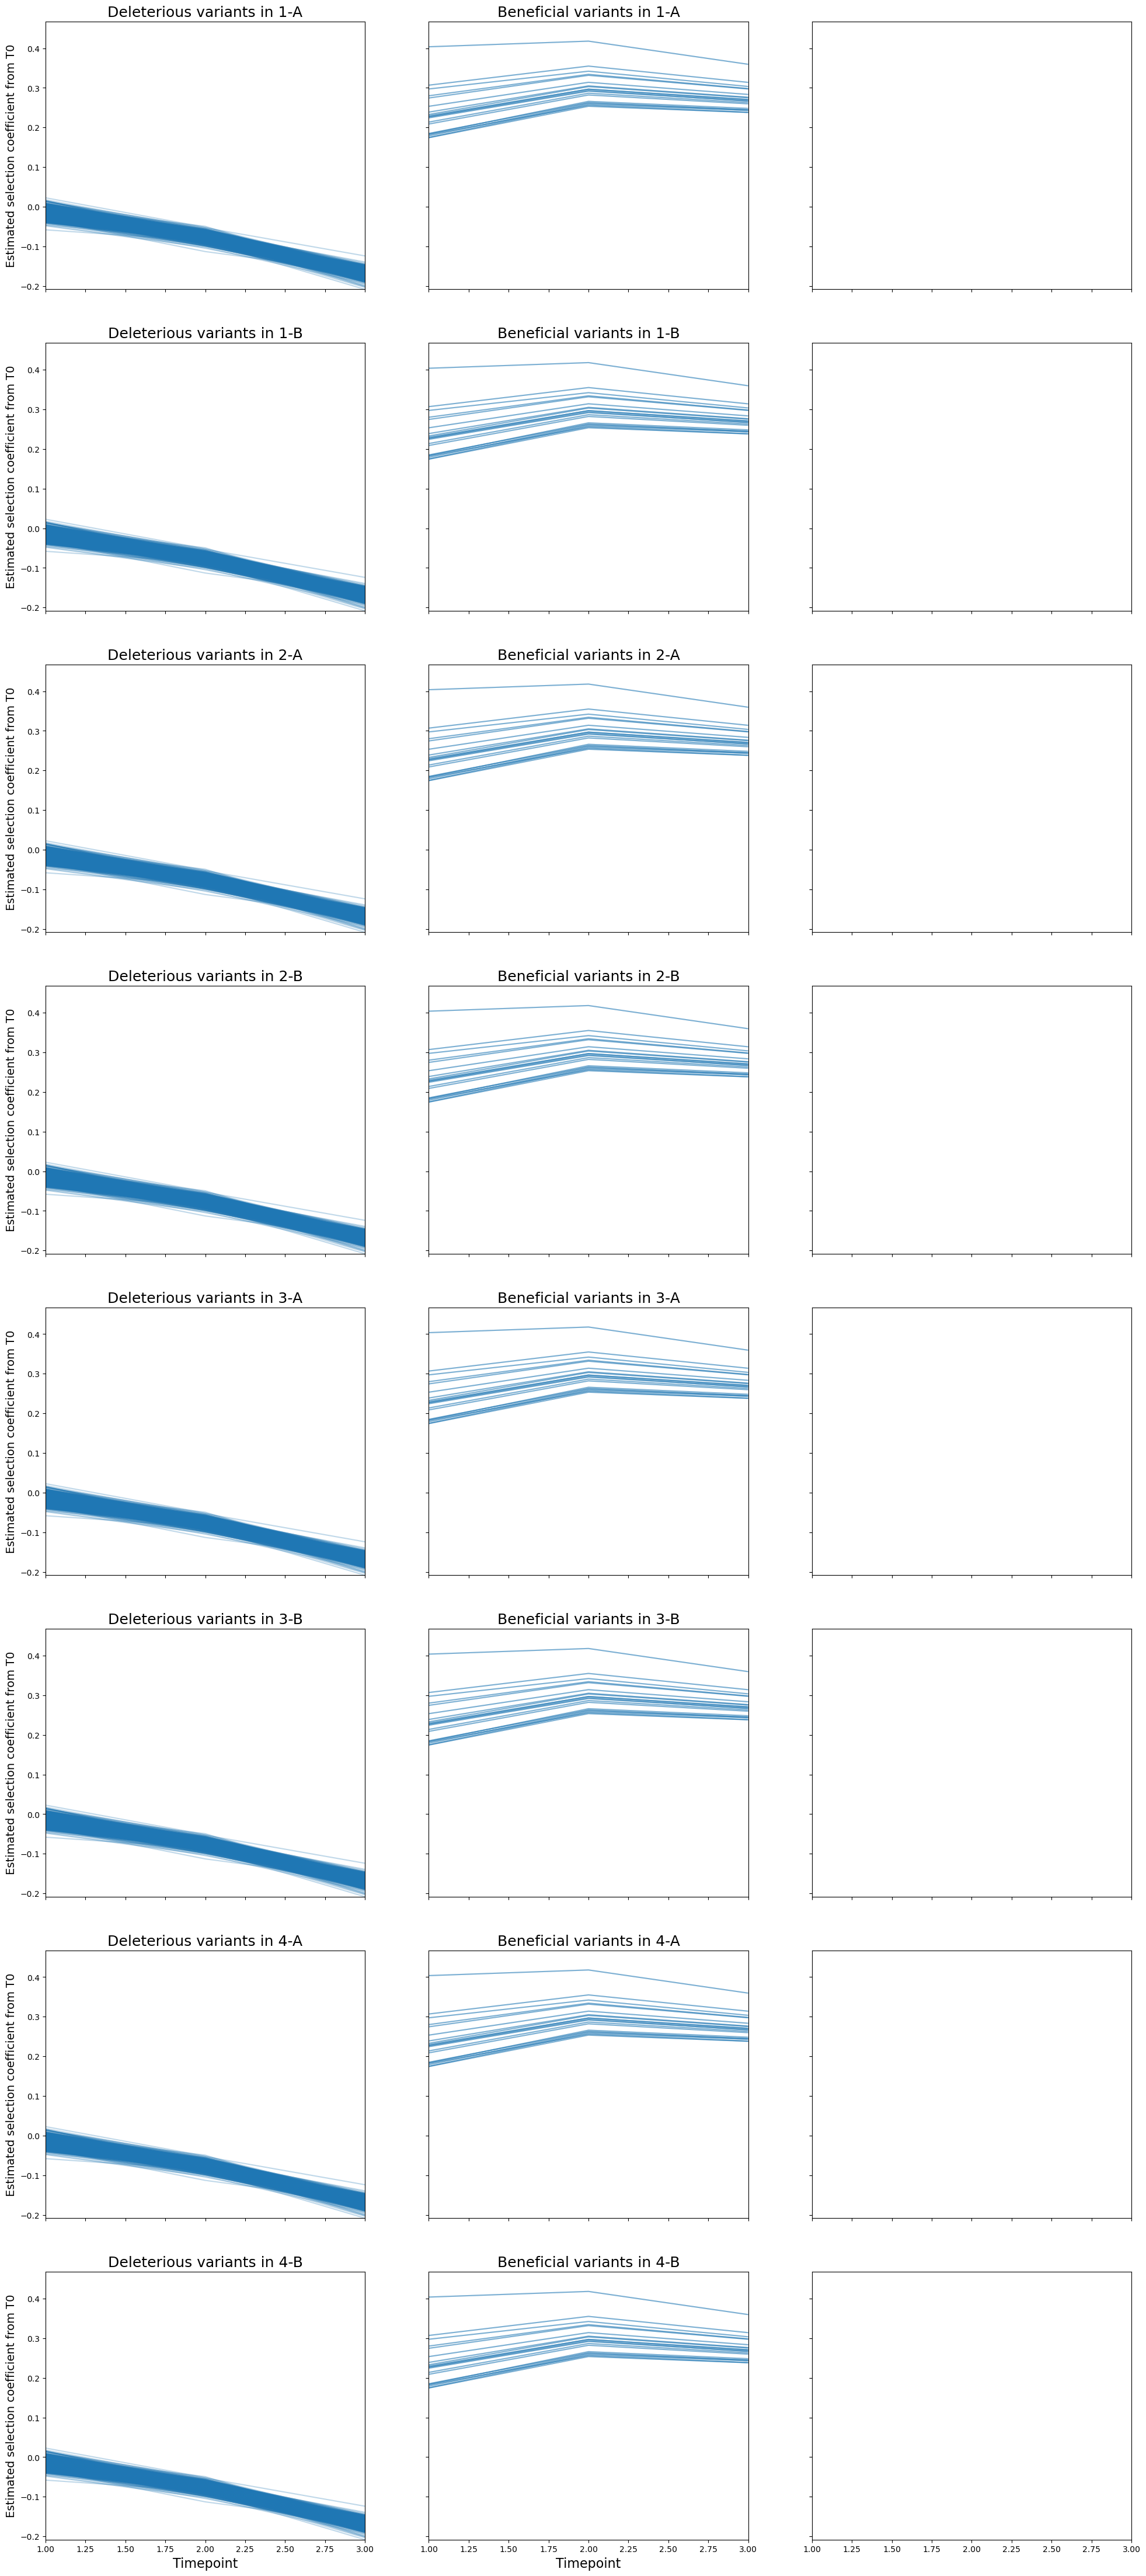

In [33]:
# First, for the 'apparent' selection coefficients

max_s = np.max(s_labels[['s_T0toT1', 's_T0toT2', 's_T0toT3']])
min_s = np.min(s_labels[['s_T0toT1', 's_T0toT2', 's_T0toT3']])

fig, axs = plt.subplots(8, 3, figsize=(24, 56), sharex=True, sharey=True)

row_num = 0

s_vals = s_labels[s_labels['Genotype'] != 'WT'].copy().reset_index(drop=True)
s_vals['T3_class'] = s_vals['s_T0toT3'].apply(lambda s: 'Beneficial' if s >= 0.05 else 'Deleterious' if s <= -0.05 else 'Neutral')

for lib_id in s_labels['Library'].unique():
    s_sub = s_vals[s_vals['Library'] == lib_num].copy().reset_index(drop=True).infer_objects()
    
    col_num = 0

    for var_type in s_sub['T3_class'].unique():
        var_sub = s_sub[s_sub['T3_class'] == var_type].copy().reset_index(drop=True)


        # Preparing the list of timeseries
        y_list = []
        x_vals = [1, 2, 3]

        # Adding the data for each variant
        for variant in var_sub['Genotype'].unique():
            var_current = var_sub[var_sub['Genotype'] == variant].copy().reset_index(drop=True)

            # Formatting and adding the timeseries
            var_current = var_current[['Genotype', 's_T0toT1', 's_T0toT2', 's_T0toT3']].copy()
            var_current = pd.melt(var_current, id_vars='Genotype', value_vars=['s_T0toT1', 's_T0toT2', 's_T0toT3'], value_name='s',
                                 var_name='Interval')
            int_dict = {'s_T0toT1': 1, 's_T0toT2': 2, 's_T0toT3': 3}
            var_current['Interval'] = var_current['Interval'].apply(lambda x: int_dict[x])
            var_current = var_current.sort_values(by='Interval')

            y_list += [list(var_current['s'])]

        # Plotting the lines
        lines_data = [np.column_stack([x_vals, y]) for y in y_list]
        if var_type == 'Beneficial':
            line_segments = LineCollection(lines_data, alpha=0.35)

        else:
            line_segments = LineCollection(lines_data, alpha=0.15)

        axs[row_num, col_num].set_xlim(np.min(x_vals), np.max(x_vals))
        axs[row_num, col_num].set_ylim(min_s, max_s)
        
        axs[row_num, col_num].add_collection(line_segments)
        fig_obj = axs[row_num, col_num].add_collection(line_segments)


        axs[row_num, col_num].set_title(f'{var_type} variants in {lib_id}', fontsize=18)
        if col_num == 0:
            axs[row_num, col_num].set_ylabel('Estimated selection coefficient from T0', fontsize=14)

        if row_num == 7:
            axs[row_num, col_num].set_xlabel('Timepoint', fontsize=16)

        col_num += 1

    row_num += 1


fig_s_traj = plt.gcf()
fig_s_traj.savefig(f"Sim_results/{run_name}/s_app_traj_{run_name}.pdf", bbox_inches='tight')

This is qualitatively what we observed in the original FCY1 F3F4 screen!

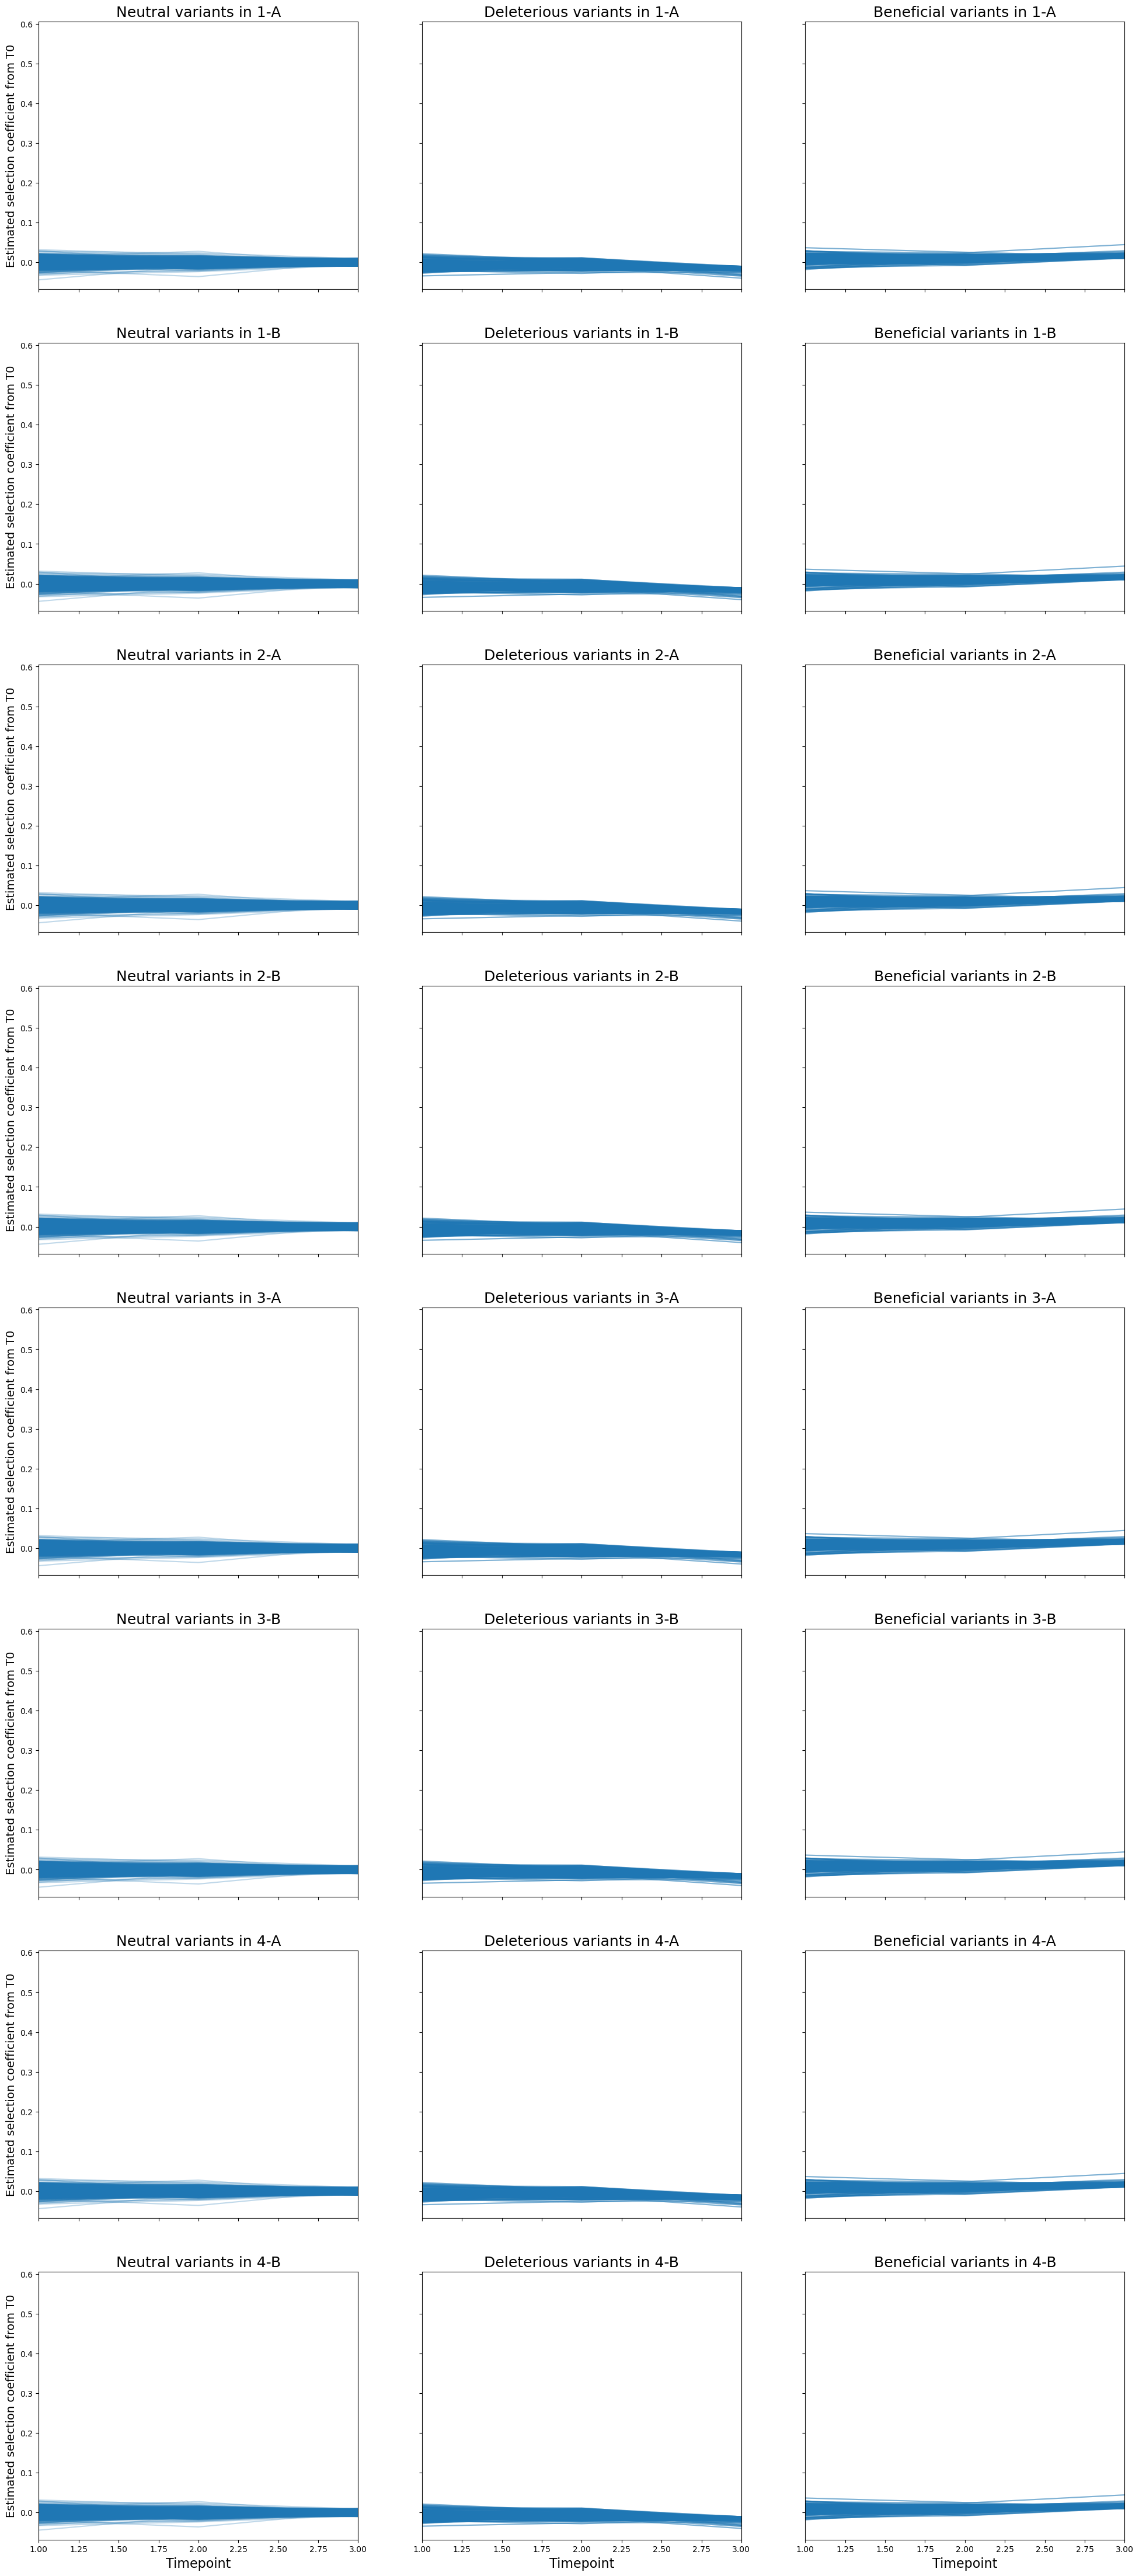

In [35]:
# Second, for the selection coefficients when the 'True genotypes' are known
max_s = np.max(s_true_genotypes[['s_T0toT1', 's_T0toT2', 's_T0toT3']])
min_s = np.min(s_true_genotypes[['s_T0toT1', 's_T0toT2', 's_T0toT3']])

fig, axs = plt.subplots(8, 3, figsize=(24, 56), sharex=True, sharey=True)

row_num = 0

s_vals = s_true_genotypes[(s_true_genotypes['Genotype'] != 'WT') & (s_true_genotypes['Genotype'] != 'Resistant')].copy().reset_index(drop=True)
s_vals['T3_class'] = s_vals['s_T0toT3'].apply(lambda s: 'Beneficial' if s >= 0.01 else 'Deleterious' if s <= -0.01 else 'Neutral')

for lib_id in s_labels['Library'].unique():
    s_sub = s_vals[s_vals['Library'] == lib_num].copy().reset_index(drop=True).infer_objects()
    
    col_num = 0

    for var_type in s_sub['T3_class'].unique():
        var_sub = s_sub[s_sub['T3_class'] == var_type].copy().reset_index(drop=True)


        # Preparing the list of timeseries
        y_list = []
        x_vals = [1, 2, 3]

        # Adding the data for each variant
        for variant in var_sub['Genotype'].unique():
            var_current = var_sub[var_sub['Genotype'] == variant].copy().reset_index(drop=True)

            # Formatting and adding the timeseries
            var_current = var_current[['Genotype', 's_T0toT1', 's_T0toT2', 's_T0toT3']].copy()
            var_current = pd.melt(var_current, id_vars='Genotype', value_vars=['s_T0toT1', 's_T0toT2', 's_T0toT3'], value_name='s',
                                 var_name='Interval')
            int_dict = {'s_T0toT1': 1, 's_T0toT2': 2, 's_T0toT3': 3}
            var_current['Interval'] = var_current['Interval'].apply(lambda x: int_dict[x])
            var_current = var_current.sort_values(by='Interval')

            y_list += [list(var_current['s'])]

        # Plotting the lines
        lines_data = [np.column_stack([x_vals, y]) for y in y_list]
        if var_type == 'Beneficial':
            line_segments = LineCollection(lines_data, alpha=0.35)

        elif var_type == 'Deleterious':
            line_segments = LineCollection(lines_data, alpha=0.35)

        else:
            line_segments = LineCollection(lines_data, alpha=0.15)

        axs[row_num, col_num].set_xlim(np.min(x_vals), np.max(x_vals))
        axs[row_num, col_num].set_ylim(min_s, max_s)
        
        axs[row_num, col_num].add_collection(line_segments)
        fig_obj = axs[row_num, col_num].add_collection(line_segments)


        axs[row_num, col_num].set_title(f'{var_type} variants in {lib_id}', fontsize=18)
        if col_num == 0:
            axs[row_num, col_num].set_ylabel('Estimated selection coefficient from T0', fontsize=14)

        if row_num == 7:
            axs[row_num, col_num].set_xlabel('Timepoint', fontsize=16)

        col_num += 1

    row_num += 1


fig_s_traj = plt.gcf()
fig_s_traj.savefig(f"Sim_results/{run_name}/s_true_traj_{run_name}.pdf", bbox_inches='tight')

4) Correlations between inferred selection coefficients and ground truth values

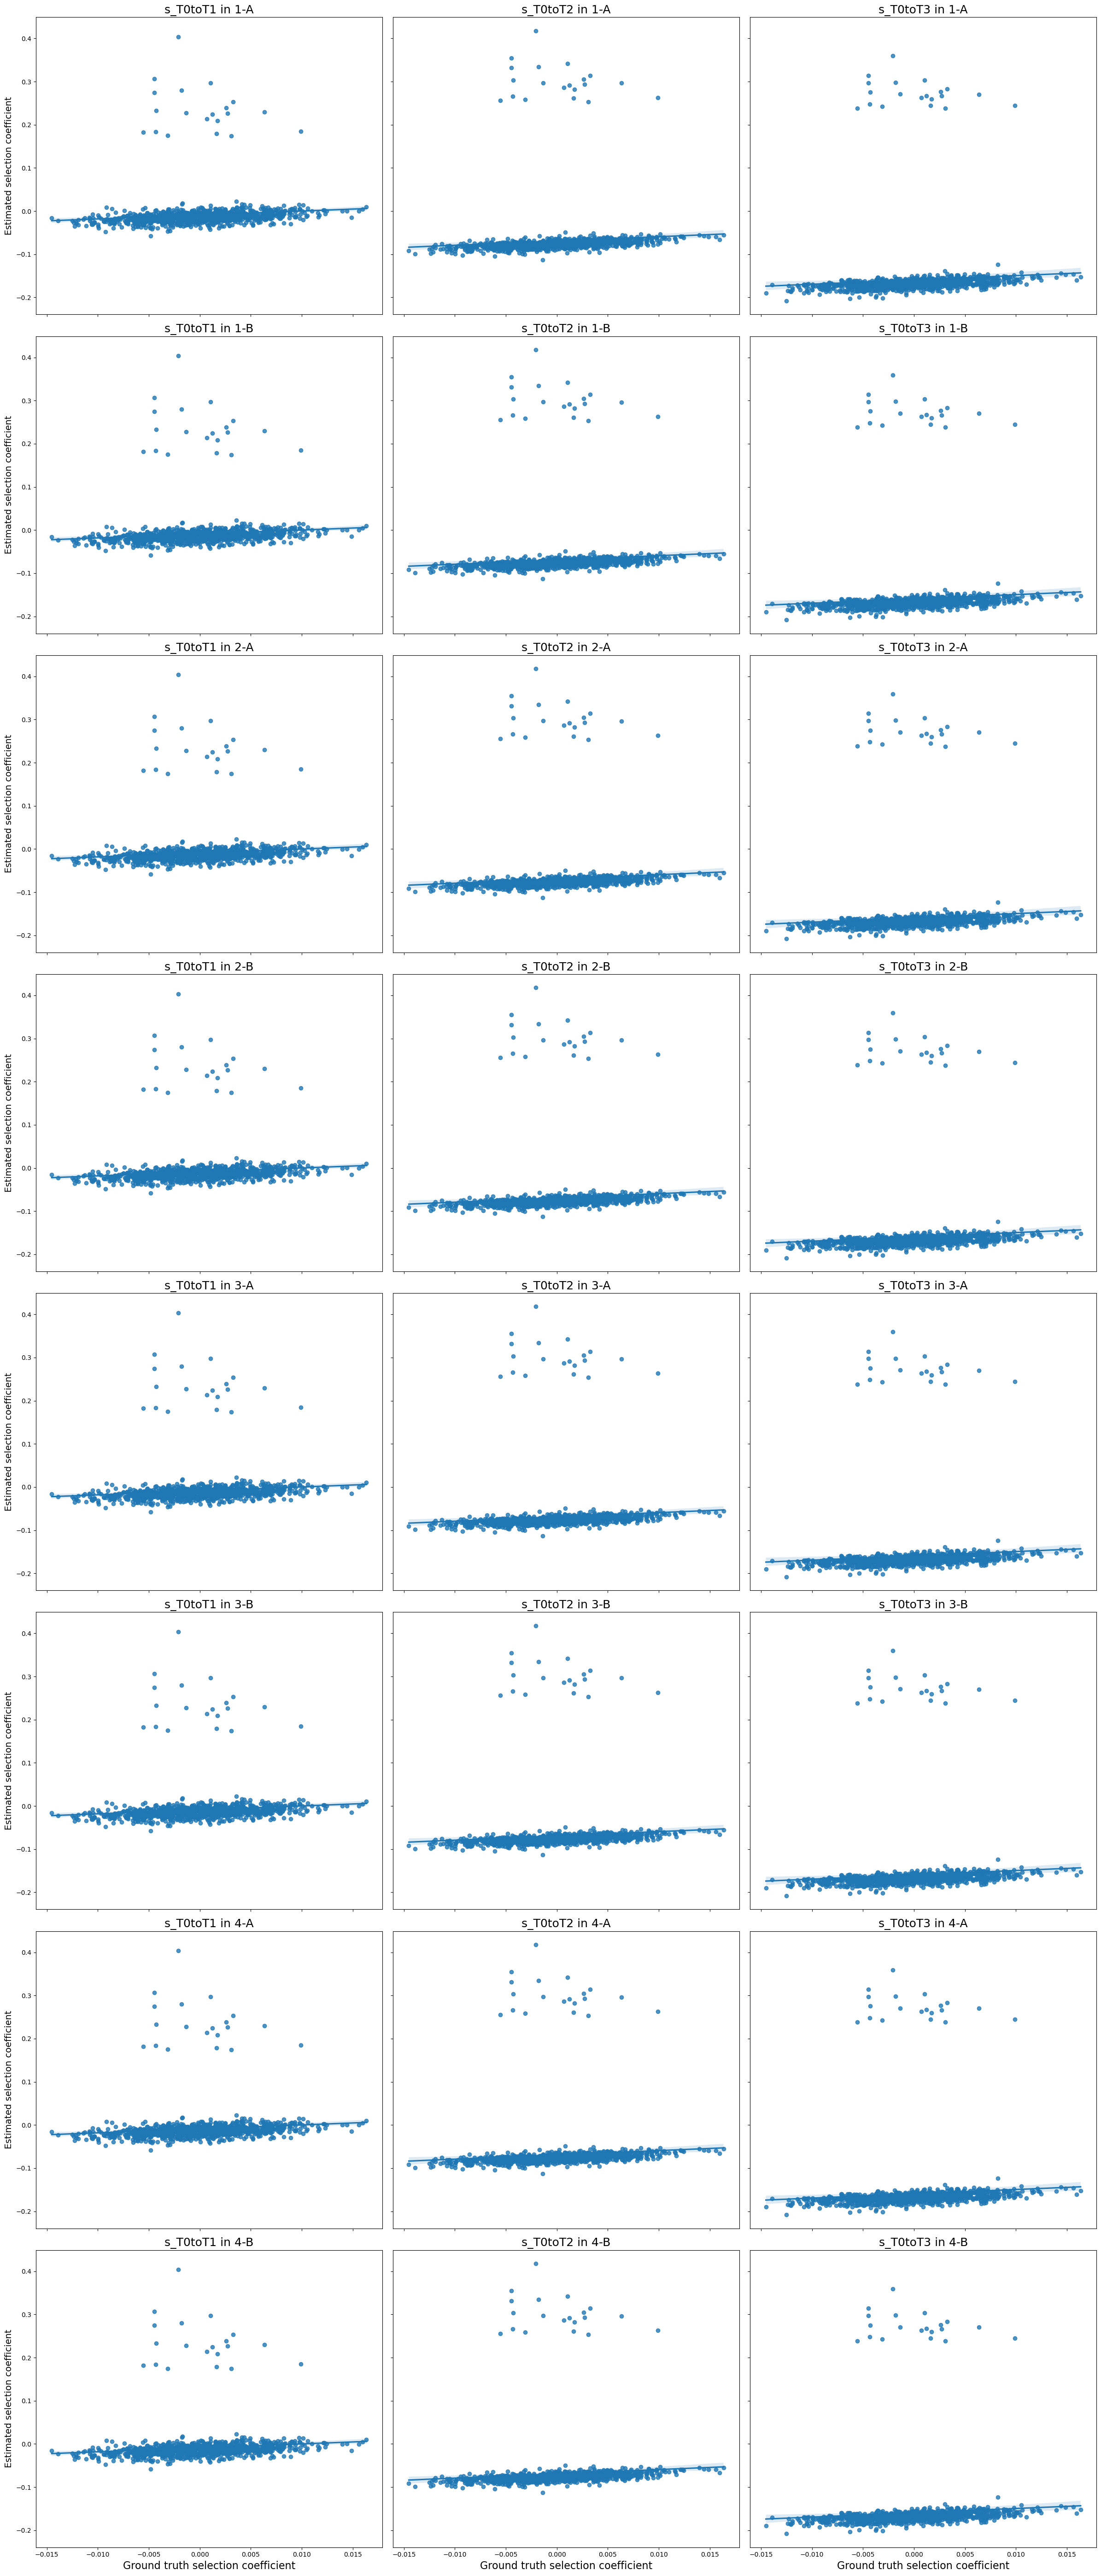

In [37]:
# First for the apparent selection coefficients
s_labels_ready = s_labels[s_labels['Genotype'] != 'WT'].copy().reset_index(drop=True)
genotypes_df = genotypes_df.rename(columns={'Label': 'Genotype', 's': 'True s'})

s_labels_comp = pd.merge(s_labels_ready, genotypes_df, how='outer', on='Genotype')

# Generating the scatterplots
fig, axs = plt.subplots(8, 3, figsize=(24, 56), sharex=True, sharey=True)

row_num = 0

for lib_id in s_labels_comp['Library'].unique():

    s_sub = s_labels_comp[s_labels_comp['Library'] == lib_num].copy().reset_index(drop=True).infer_objects()

    col_num = 0

    for time_int in ['s_T0toT1', 's_T0toT2', 's_T0toT3']:
        new_reg = sns.regplot(x='True s', y=time_int, data=s_sub, ax=axs[row_num, col_num])
        axs[row_num, col_num].set_title(f'{time_int} in {lib_id}', fontsize=18)

        pearson_current = stats.pearsonr(s_sub['True s'], s_sub[time_int])
        
        axs[row_num, col_num].annotate(r"r = "f'{round(pearson_current[0], 3)}\np-val = {pearson_current[1]:.3e}',
                                       (-0.06, 0.05), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=15)

        axs[row_num, col_num].set_ylabel('')
        axs[row_num, col_num].set_xlabel('')

        if col_num == 0:
            axs[row_num, col_num].set_ylabel('Estimated selection coefficient', fontsize=14)

        if row_num == 7:
            axs[row_num, col_num].set_xlabel('Ground truth selection coefficient', fontsize=16)

        col_num += 1

    row_num += 1


#fig.suptitle("Comparisons of true and inferred s values, with 'unseen' resistant mutants", fontsize=20)
plt.tight_layout()
fig_corr = plt.gcf()
fig_corr.savefig(f"Sim_results/{run_name}/s_app_comps_{run_name}.pdf", bbox_inches='tight')

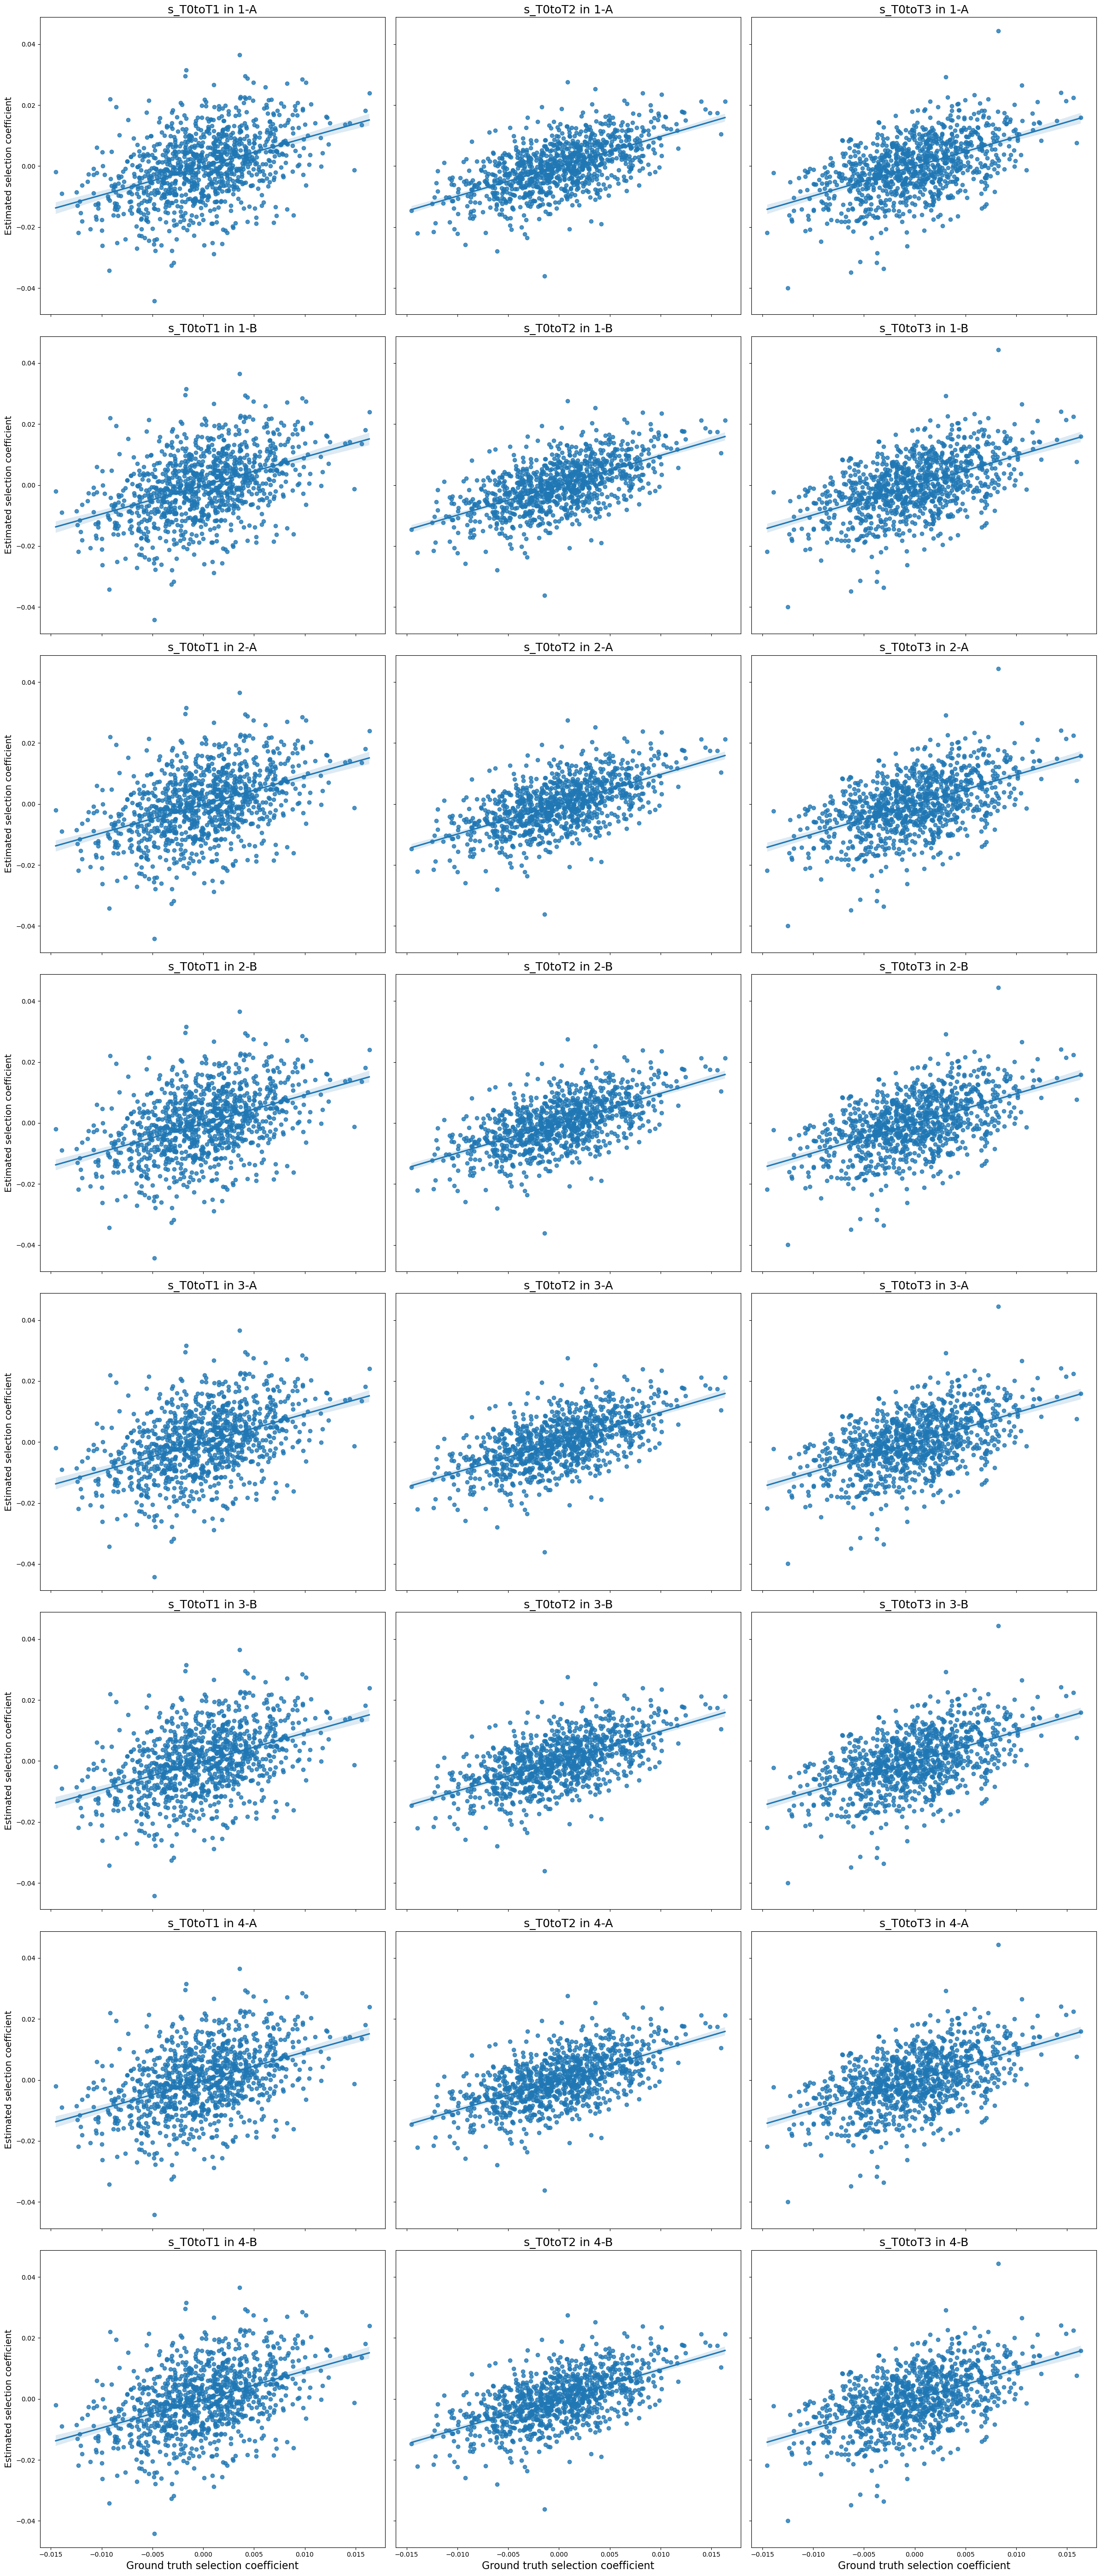

In [38]:
# Second, for the inference when unwanted resistance-conferring mutations are correctly removed
s_true_ready = s_true_genotypes[(s_true_genotypes['Genotype'] != 'WT') & (s_true_genotypes['Genotype'] != 'Resistant')].copy().reset_index(drop=True)
#genotypes_df = genotypes_df.rename(columns={'Label': 'Genotype', 's': 'True s'})

s_true_comp = pd.merge(s_true_ready, genotypes_df, how='outer', on='Genotype')

# Generating the scatterplots
fig, axs = plt.subplots(8, 3, figsize=(24, 56), sharex=True, sharey=True)

row_num = 0

for lib_id in s_true_comp['Library'].unique():

    s_sub = s_true_comp[s_true_comp['Library'] == lib_num].copy().reset_index(drop=True).infer_objects()

    col_num = 0

    for time_int in ['s_T0toT1', 's_T0toT2', 's_T0toT3']:
        new_reg = sns.regplot(x='True s', y=time_int, data=s_sub, ax=axs[row_num, col_num])
        axs[row_num, col_num].set_title(f'{time_int} in {lib_id}', fontsize=18)

        pearson_current = stats.pearsonr(s_sub['True s'], s_sub[time_int])
        
        axs[row_num, col_num].annotate(r"r = "f'{round(pearson_current[0], 3)}\np-val = {pearson_current[1]:.3e}',
                                       (0, -0.1), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=15)

        axs[row_num, col_num].set_ylabel('')
        axs[row_num, col_num].set_xlabel('')

        if col_num == 0:
            axs[row_num, col_num].set_ylabel('Estimated selection coefficient', fontsize=14)

        if row_num == 7:
            axs[row_num, col_num].set_xlabel('Ground truth selection coefficient', fontsize=16)

        col_num += 1

    row_num += 1

plt.tight_layout()
fig_corr = plt.gcf()
fig_corr.savefig(f"Sim_results/{run_name}/s_true_comps_{run_name}.pdf", bbox_inches='tight')

As shown by the comparisons above - for the case where all resistance-conferring mutations are correctly filtered out - the small selection coefficients which we have assumed really are at the limit resolution of the experiment. And this simulation is 'perfect' compared to the real experiment!

### Grid searches of the parameter space

#### Defining functions to more easily perform multiple simulations

In [42]:
# 1) The BigLoop
def perform_sim(n_variants, dist_tuple, current_seed, transfos_list, replicates_list, n_clones, wt_freq, mut_freq,
                mut_s, starting_pop, labels_col, reals_col, timepoints, gen_dict, seq_reads):
    """Defining the previous loop as a function.
    n_variants = Number of variants (genotypes) to generate per pool
    dist_tuple = Tuple of (mean, sd) for the true distribution of mutational effects (selection coefficients)
    current_seed = Seed for RNG
    transfos_list = List of ids for the transformation replicates to be generated
    replicates_list = List of ids for the culture replicates to be generated (successively from each transformation replicate)
    n_clones = Total number of clones collected when initially constructing the mutant library
    wt_freq = Frequency of the WT genotype in the mutant library
    mut_freq = Frequency of (invisible) secondary mutations within the mutant library.
    mut_s = Effect (selection coefficient) of secondary mutations. Only one float of arbitrary magnitude
    starting_pop = Number of cells inoculated in liquid media at the start of each passage
    labels_col = Name of the column containing the 'apparent' label of each genotype (ignoring secondary mutations)
    reals_col = Name of the column containing the 'real' label of each genotype (taking into account secondary mutations)
    timepoints = List of timepoints or passages (string ids) for which the screen should be simulated. Should be in order and names sequentially from T0 to Tn (no gaps)!
    gen_dict = Dictionary of duration, in generations, for each timepoint included in the previous list
    seq_reads = Number of sequencing reads to sample each time a timepoint is sequenced."""

    # Generating a model df to be used later
    df_all_model = pd.DataFrame(columns=[labels_col, reals_col, 'Bio_rep', 'Tech_rep', 'Timepoint', 'N_reads'])

    # Defining the rng to be used across the BigLoop
    loop_rng = np.random.default_rng(current_seed)

    # Generating the ground truth label -> s mapping
    genotypes_df, genotypes_dict = get_labels(n_variants, dist_tuple, resist_s=mut_s, rng_to_use=loop_rng)

    # Performing the simulation
    df_current_sim = df_all_model.copy()

    for bio_rep in transfos_list:  # Generating a new set of clones ('transformation') for each transformation replicate
        clones_current = get_transfo(genotypes_df, genotypes_dict, n_clones, wt_freq, mut_freq, rng_to_use=loop_rng)

        for tech_rep in replicates_list:  # Sampling independently to generate each culture replicate
            init_pop = get_starting_pop(clones_current, starting_pop, rng_to_use=loop_rng)
            
            # Obtain the initial wt-relative frequencies
            init_freqs = pop_to_frequencies(init_pop, labels_col, reals_col)

            # Sample T0 sequencing reads and add to the df
            T0_freqs = init_freqs.copy()
            T0_freqs['Total_rel'] = T0_freqs['WT_rel'] / np.sum(T0_freqs['WT_rel'])
            index_T0 = loop_rng.choice(list(T0_freqs.index), size=int(seq_reads), replace=True, p=T0_freqs['Total_rel'])
            T0_reads = T0_freqs.loc[index_T0, :].copy()
            T0_reads['Count'] = 1
            T0_reads = T0_reads.drop(columns=['Total_rel'])
            T0_reads = T0_reads.groupby(by=[labels_col, reals_col], as_index=False).sum()
            T0_reads = T0_reads.rename(columns={'Count': 'N_reads'})

            current_T0 = df_all_model.copy()
            current_T0[[labels_col, reals_col, 'N_reads']] = T0_reads[[labels_col, reals_col, 'N_reads']].copy()
            current_T0['Bio_rep'] = bio_rep
            current_T0['Tech_rep'] = tech_rep
            current_T0['Timepoint'] = 'T0'
            df_current_sim = pd.concat([df_current_sim, current_T0])

            # Simulate the three timepoints
            current_init = init_freqs.copy()
        
            for time_id in timepoints:
                passage_gen = gen_dict[time_id]
                next_init, current_reads = sim_passage(current_init, passage_gen, starting_pop, seq_reads, labels_col, reals_col, genotypes_dict,
                                                       rng_to_use=loop_rng)

                current_time = df_all_model.copy()
                current_time[[labels_col, reals_col, 'N_reads']] = current_reads[[labels_col, reals_col, 'N_reads']].copy()
                current_time['Bio_rep'] = bio_rep
                current_time['Tech_rep'] = tech_rep
                current_time['Timepoint'] = time_id
                df_current_sim = pd.concat([df_current_sim, current_time]).reset_index(drop=True)

                current_init = next_init

    # Add a 'Library' column to the df_current_sim before returning it
    df_current_sim['Library'] = df_current_sim['Bio_rep'] + '-' + df_current_sim['Tech_rep']

    return df_current_sim

In [43]:
# 2) Function to execute the selection coefficient calculations from the returned df
def get_s_from_sim(timepoints, gen_dict, df_sim, labels_col, reals_col):
    """Function to obtain selection coefficients, using both 'apparent' and 'real' genotypes, from a simulation.
    timepoints = List of timepoints or passages (string ids) for which the screen should be simulated. Should be in order and names sequentially from T0 to Tn (no gaps)!
    gen_dict = Dictionary of duration, in generations, for each timepoint included in the previous list
    df_sim = Dataframe returned by the perform_sim() function
    labels_col = Name of the column containing the 'apparent' label of each genotype (ignoring secondary mutations)
    reals_col = Name of the column containing the 'real' label of each genotype (taking into account secondary mutations)"""

    # Generating of dictionary of cumulative generations for each timepoint
    gen_total = {}
    tot_gen = 0

    for time_id in ['T0', 'T1', 'T2', 'T3']:
        gen_to_add = gen_dict[time_id]
        tot_gen += gen_to_add
        gen_total[time_id] = tot_gen

    # Perfoming the selection coefficient calculation
    s_labels = compile_s(df_sim, labels_col, 'Library', gen_total)

    s_true_genotypes = compile_s(df_sim, reals_col, 'Library', gen_total)

    return s_labels, s_true_genotypes

In [44]:
# 3) Function to perform a grid search for any two chosen parameters
def search_grid(constants_dict, search_dict, n_reps, n_seeds, run_name, out_dir, s_threshold, t_final, raw_dir=None, save_raw=False):
    """Function to perform a grid search of simulations using perform_sim().
    constants_dict = Dictionary of perform_sim() arguments which remain constant throughout the grid_search
    search_dict = Dictionary of the two parameters which are to be varied in the current grid search. Provide a list of values for each key.
    n_reps = Number of replicate simulations to perform for each combination of parameter values
    n_seeds = List of seeds to initizalize a default_rng() instance at the beginning of each replicate simulation. There should be as many as there are n_reps
    run_name = Identifier of the run (for saving summary statistics in a file)
    out_dir = Directory where summary statistics should be saved
    s_threshold = Median selection coefficient (absolute value) past which culture replicates within a simulation are considered 'biased'
    t_final = Timepoint (of the form 'Tn') to be considered at Tfinal when computing summary statistics. Needs to be included in the 'timepoints' list
              given as part of constants_dict.
    out_raw = Directory where the raw data files should be saved (needs to be within the specified out_dir. Only used if save_raw is set to True"""
    # Extracting the parameters to be varied
    params = list(search_dict.keys())
    if len(params) != 2:
        raise Exception('The grid search currently only supports varying two parameters per run.')
    param_a = params[0]
    vals_a = search_dict[param_a]
    param_b = params[1]
    vals_b = search_dict[param_b]

    # Generating a df within which all the summary statistics will be compiled
    summary_model = pd.DataFrame(columns=['Run_name', param_a, param_b, 'Replicate', 'Grand_med_s_app', 'Grand_med_s_true',
                                         'Min_med_s_app', 'Max_med_s_app', 'Min_med_s_true', 'Max_med_s_true', 'N_biased_cultures',
                                         'N_biased_transfos', 'Min_pearson_s_app', 'Max_pearson_s_app', 'Min_spearman_s_app', 'Max_spearman_s_app',
                                         'Min_pearson_s_true', 'Max_pearson_s_true', 'Min_spearman_s_true', 'Max_spearman_s_true'])
    stats_df = summary_model.copy()

    # Running n_reps simulations for each combination of parameter values
    for a_val in vals_a:

        for b_val in vals_b:
            grid_dict = {param_a: a_val, param_b: b_val}
            current_dict = deepcopy(constants_dict)
            current_dict.update(grid_dict)

            for sim_rep in range(n_reps):
                seed_to_use = n_seeds[sim_rep]
                rep_dict = deepcopy(current_dict)
                rep_dict.update({'current_seed': seed_to_use})
                sim_df = perform_sim(**rep_dict)

                # Computing selection coefficients for the current simulation
                s_labels, s_true = get_s_from_sim(timepoints=rep_dict['timepoints'], gen_dict=rep_dict['gen_dict'],
                                                  df_sim=sim_df, labels_col=rep_dict['labels_col'], reals_col=rep_dict['reals_col'])

                # Dropping the WT from each df
                s_labels = s_labels[s_labels['Genotype'] != 'WT'].copy().reset_index(drop=True)
                s_true = s_true[s_true['Genotype'] != 'WT'].copy().reset_index(drop=True)

                # Saving the raw data for the current simulation replicate
                sim_params = f'{param_a}_{a_val}_{param_b}_{b_val}_Rep{sim_rep}'.replace('.', '-')
                if save_raw and raw_dir:
                    sim_df.to_csv(f'{out_dir}/{raw_dir}/{sim_params}.csv', index=False)
                    s_labels.to_csv(f'{out_dir}/{raw_dir}/s_app{sim_params}.csv', index=False)
                    s_true.to_csv(f'{out_dir}/{raw_dir}/s_true{sim_params}.csv', index=False)

                # Computing summary statistics and adding them to stats_df
                current_stats = summary_model.copy()
                current_stats.at[0, 'Run_name'] = run_name
                current_stats.at[0, param_a] = a_val
                current_stats.at[0, param_b] = b_val
                current_stats.at[0, 'Replicate'] = sim_rep

                # A) Medians of selection coefficients
                s_labels_med = s_labels[['Library', f's_T0to{t_final}']].copy().groupby(by=['Library'], as_index=False).median()
                current_stats.at[0, 'Grand_med_s_app'] = np.median(s_labels_med[f's_T0to{t_final}'])
                current_stats.at[0, 'Min_med_s_app'] = np.min(s_labels_med[f's_T0to{t_final}'])
                current_stats.at[0, 'Max_med_s_app'] = np.max(s_labels_med[f's_T0to{t_final}'])
                
                s_true_med = s_true[['Library', f's_T0to{t_final}']].copy().groupby(by=['Library'], as_index=False).median()
                current_stats.at[0, 'Grand_med_s_true'] = np.median(s_true_med[f's_T0to{t_final}'])
                current_stats.at[0, 'Min_med_s_true'] = np.min(s_true_med[f's_T0to{t_final}'])
                current_stats.at[0, 'Max_med_s_true'] = np.max(s_true_med[f's_T0to{t_final}'])

                # B) Number of biased cultures and transformations
                s_labels_med['Biased'] = np.abs(s_labels_med[f's_T0to{t_final}']) > s_threshold
                current_stats.at[0, 'N_biased_cultures'] = np.sum(s_labels_med['Biased'])
                s_labels_med['Transformation'] = s_labels_med['Library'].apply(lambda x: x.split('-')[0])
                transfo_labels = s_labels_med[['Transformation', 'Biased']].copy().groupby(by=['Transformation'], as_index=False).sum()
                current_stats.at[0, 'N_biased_transfos'] = transfo_labels[transfo_labels['Biased'] == len(rep_dict['replicates_list'])].shape[0]

                # C) Correlations between libraries of the same simulation replicate
                sets_list = []  # To keep track of combinations which have already been done
                rho_app_list = []  # To store Spearman correlation coefficients
                rho_true_list= []
                r_app_list = []  # To store Pearson correlation coefficients 
                r_true_list = []
                
                for lib_a in s_labels_med['Library'].unique():

                    for lib_b in s_labels_med['Library'].unique():

                        # Do not compute correlation of a sample with itself
                        if lib_a == lib_b:
                            continue
                        # Do not compute correlations if the current combination has already been done
                        lib_comb = set([lib_a, lib_b])

                        if lib_comb in sets_list:
                            continue

                        else:
                            sets_list += [lib_comb]

                        # Computing correlations if needed
                        # In some cases, one or few variant(s) will be lost in one replicate during the simulation. This then creates NaN
                        # upon merging with other replicates of the same simulation. This is why any NaN values are dropped before the
                        # correlations are computed.
                        a_labels = s_labels[s_labels['Library'] == lib_a].copy().reset_index(drop=True)[['Genotype', f's_T0to{t_final}']]
                        b_labels = s_labels[s_labels['Library'] == lib_b].copy().reset_index(drop=True)[['Genotype', f's_T0to{t_final}']] 
                        merged_labels = pd.merge(a_labels, b_labels, on=['Genotype'], how='outer', suffixes=('_a', '_b'))
                        merged_labels = merged_labels.dropna(subset=[f's_T0to{t_final}_a', f's_T0to{t_final}_b']).copy().reset_index(drop=True)
                        rho_labels = stats.spearmanr(merged_labels[f's_T0to{t_final}_a'], merged_labels[f's_T0to{t_final}_b'])[0]
                        rho_app_list += [rho_labels]
                        r_labels = stats.pearsonr(merged_labels[f's_T0to{t_final}_a'], merged_labels[f's_T0to{t_final}_b'])[0]
                        r_app_list += [r_labels]

                        a_true = s_true[s_true['Library'] == lib_a].copy().reset_index(drop=True)[['Genotype', f's_T0to{t_final}']]
                        b_true = s_true[s_true['Library'] == lib_b].copy().reset_index(drop=True)[['Genotype', f's_T0to{t_final}']] 
                        merged_true = pd.merge(a_true, b_true, on=['Genotype'], how='outer', suffixes=('_a', '_b'))
                        merged_true = merged_true[merged_true['Genotype'] != 'Resistant'].copy().reset_index(drop=True)  # To avoid inflating r and rho
                        merged_true = merged_true.dropna(subset=[f's_T0to{t_final}_a', f's_T0to{t_final}_b']).copy().reset_index(drop=True)
                        rho_true = stats.spearmanr(merged_true[f's_T0to{t_final}_a'], merged_true[f's_T0to{t_final}_b'])[0]
                        rho_true_list += [rho_true]
                        r_true = stats.pearsonr(merged_true[f's_T0to{t_final}_a'], merged_true[f's_T0to{t_final}_b'])[0]
                        r_true_list += [r_true]

                # Once all the computations have been done, compile correlation summary statistics for the current simulation replicate
                current_stats.at[0, 'Min_pearson_s_app'] = r_app_list[np.argmin(np.abs(r_app_list))]
                current_stats.at[0, 'Max_pearson_s_app'] = r_app_list[np.argmax(np.abs(r_app_list))]
                current_stats.at[0, 'Min_spearman_s_app'] = rho_app_list[np.argmin(np.abs(rho_app_list))]
                current_stats.at[0, 'Max_spearman_s_app'] = rho_app_list[np.argmax(np.abs(rho_app_list))]

                current_stats.at[0, 'Min_pearson_s_true'] = r_true_list[np.argmin(np.abs(r_true_list))]
                current_stats.at[0, 'Max_pearson_s_true'] = r_true_list[np.argmax(np.abs(r_true_list))]
                current_stats.at[0, 'Min_spearman_s_true'] = rho_true_list[np.argmin(np.abs(rho_true_list))]
                current_stats.at[0, 'Max_spearman_s_true'] = rho_true_list[np.argmax(np.abs(rho_true_list))]

                # At this point, all the summary statistics for the current simulation replicate have been computed, so the summary dfs can be concatenated
                stats_df = pd.concat([stats_df, current_stats]).reset_index(drop=True)

                print(f'Done with replicate {sim_rep} with {param_a}={a_val} and {param_b}={b_val}')

    # Returning (and saving) the df of summary statistics once the grid search has been performed
    stats_df.to_csv(f'{out_dir}/Summary_{run_name}.csv', index=False)

    return stats_df

#### First grid search: Assessing whether the remaining bias is realistic

In [46]:
# Defining the dictionaries of constants and variables
constants_bias = {'n_variants': 1000, 'dist_tuple': (0, 0.005), 'transfos_list': ['1', '2', '3', '4'], 
                  'replicates_list': ['A', 'B'], 'n_clones': 10000, 'wt_freq': 0.17, 'starting_pop': 2500000,
                  'labels_col': 'Label', 'reals_col': 'Real_genotype', 'timepoints': ['T0', 'T1', 'T2', 'T3'],
                 'gen_dict': {'T0': 0, 'T1': 5.46, 'T2': 4.50, 'T3': 3.55}, 'seq_reads': 1000000}

vars_bias = {'mut_freq': [0.00005, 0.00010, 0.00015, 0.00020, 0.00025, 0.00030, 0.00035],
             'mut_s': [0.4, 0.5, 0.6]}

In [47]:
# Choosing 15 seeds
#seeds_list = np.random.default_rng().choice(list(range(101)), 15)
seeds_list = [10, 70, 87, 20, 96, 22, 50, 69, 15,  4,  0, 75, 12, 94, 22]

In [48]:
# Launching the grid search
grid_bias = search_grid(constants_bias, vars_bias, n_reps=15, n_seeds=seeds_list, run_name='Bias_valid', out_dir='Sim_results', s_threshold=0.075, t_final='T3',
                        raw_dir='Raw_data_bias', save_raw=True)

Done with replicate 0 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 1 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 2 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 3 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 4 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 5 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 6 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 7 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 8 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 9 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 10 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 11 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 12 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 13 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 14 with mut_freq=5e-05 and mut_s=0.4
Done with replicate 0 with mut_freq=5e-05 and mut_s=0.5
Done with replicate 1 with mut_freq=5e-05 and mut_s=0.5
Done with replicate 2 with mut_freq=5e-05 a

#### Generating the corresponding S9 Fig

In [122]:
medians_bias = grid_bias[['mut_freq', 'mut_s', 'Grand_med_s_app', 'Min_med_s_app', 'Max_med_s_app',
                          'N_biased_cultures', 'N_biased_transfos']].copy().groupby(by=['mut_freq', 'mut_s'], as_index=False).median()
# Converting mut_freq in % (better for labeling figure axes)
medians_bias['mut_freq'] = medians_bias['mut_freq'] * 100
medians_bias['mut_freq'] = medians_bias['mut_freq'].apply(lambda x: round(x, 3))

In [124]:
# Making the two matrices for the A and B heatmaps
min_app_bias = medians_bias[['mut_freq', 'mut_s', 'Min_med_s_app']].copy()
min_app_bias = min_app_bias.pivot(columns='mut_s', index='mut_freq', values='Min_med_s_app')

med_bias_cultures = medians_bias[['mut_freq', 'mut_s', 'N_biased_cultures']].copy()
med_bias_cultures = med_bias_cultures.pivot(columns='mut_s', index='mut_freq', values='N_biased_cultures')

In [126]:
# Preparing a dataframe to plot all datapoints for n of biased transfos and cultures, with s=0.6
all_N_bias = grid_bias[grid_bias['mut_s'] == 0.6].copy().reset_index(drop=True)
all_N_bias['mut_freq'] = all_N_bias['mut_freq'] * 100
all_N_bias = all_N_bias[['mut_freq', 'mut_s', 'N_biased_cultures', 'N_biased_transfos']].copy()
all_N_bias = pd.melt(all_N_bias, id_vars=['mut_freq', 'mut_s'], value_vars=['N_biased_cultures', 'N_biased_transfos'],
                    value_name='N_biased', var_name='Category')

In [128]:
# Computing the probability of observing 4 or more biased cultures
tested_freqs = grid_bias['mut_freq'].unique()
list_df = []

for freq_muts in tested_freqs:
    freq_subset = grid_bias[(grid_bias['mut_freq'] == freq_muts) & (grid_bias['mut_s'] == 0.6)].copy().reset_index(drop=True)
    rep_total = freq_subset.shape[0]
    freq_subset['N_above'] = np.where(freq_subset['N_biased_cultures'] >= 4, 1, 0)
    prob_above = np.sum(freq_subset['N_above']) / rep_total

    current_dict = {'mut_freq': freq_muts*100, 'prob_above': prob_above}
    list_df += [current_dict]

prob_above_bias = pd.DataFrame(list_df)

<Axes: xlabel='mut_freq', ylabel='prob_above'>

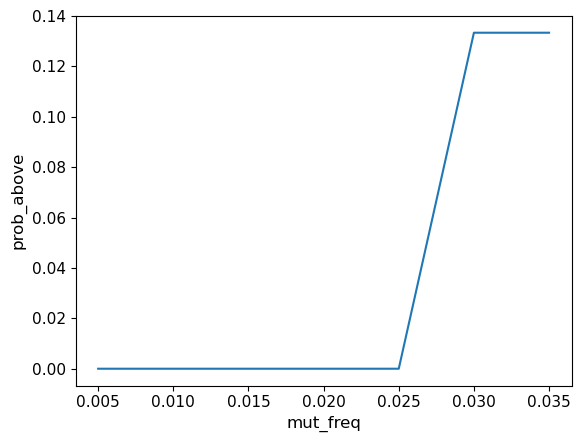

In [130]:
sns.lineplot(data=prob_above_bias, x='mut_freq', y='prob_above')

In [132]:
prob_above_bias

mut_freq  prob_above
0     0.005    0.000000
1     0.010    0.000000
2     0.015    0.000000
3     0.020    0.000000
4     0.025    0.000000
5     0.030    0.133333
6     0.035    0.133333

<Axes: xlabel='mut_freq', ylabel='N_biased'>

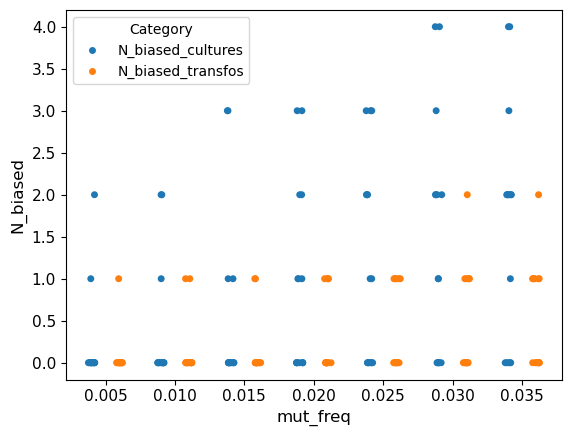

In [136]:
sns.stripplot(data=all_N_bias, x='mut_freq', y='N_biased', hue='Category', dodge=True,
             native_scale=True)

In [138]:
# Changing the labels in the all_N_biased dataframe
cat_dict = {'N_biased_cultures': 'Cultures',
            'N_biased_transfos': 'Transformations'}
all_N_bias['Category'] = all_N_bias['Category'].apply(lambda x: cat_dict[x])

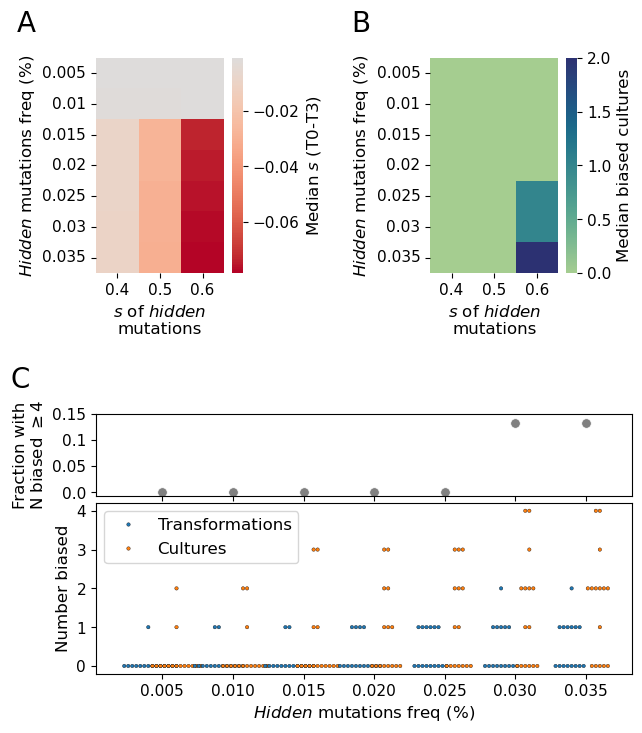

In [163]:
plt.rcParams['savefig.dpi'] = 600
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

# Preparing the figure
fig = plt.figure(figsize=(8, 8))

grid = gridspec.GridSpec(ncols=15, nrows=14, figure=fig)
ax1 = fig.add_subplot(grid[0:5, 0:4])
ax2 = fig.add_subplot(grid[0:5, 8:12])
ax3 = fig.add_subplot(grid[8:10, 0:13])
ax4 = fig.add_subplot(grid[10:14, 0:13], sharex=ax3)

# Plotting the heatmaps
map_bias = sns.heatmap(min_app_bias.infer_objects(), ax=ax1, cmap='coolwarm_r', center=0,
                       cbar_kws={'label': r"Median $s$ (T0-T3)"})

map_number = sns.heatmap(med_bias_cultures.infer_objects(), ax=ax2, cmap='crest',
                         cbar_kws={'label': r"Median biased cultures"})

# Labeling the axes
ax1.set_ylabel(r"$\it{Hidden}$ mutations freq (%)")
ax1.set_xlabel(r"$s$ of $\it{hidden}$" '\n' 'mutations')
ax2.set_ylabel(r"$\it{Hidden}$ mutations freq (%)")
ax2.set_xlabel(r"$s$ of $\it{hidden}$" '\n' 'mutations')


# Plotting the disributions of biased replicates
swarm_N = sns.swarmplot(data=all_N_bias, x='mut_freq', y='N_biased', hue='Category', dodge=True,
                        native_scale=True, ax=ax4, size=2.5, hue_order=['Transformations', 'Cultures'],
                        edgecolor='black', linewidth=0.25)
swarm_N.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12,
               title='')
ax4.set_xlabel(r"$\it{Hidden}$ mutations freq (%)")
ax4.set_ylabel('Number biased')

# Plotting the probability of >=4 biased cultures
sns.scatterplot(data=prob_above_bias, x='mut_freq', y='prob_above', ax=ax3, color='grey', s=48)
ax3.tick_params(labelbottom=False)
ax3.set_xlabel('')
ax3.set_ylabel('Fraction with' '\n' r"N biased $\geq 4$")
ax3.set_yticks([0.0, 0.05, 0.10, 0.15], labels=[0.0, 0.05, 0.10, 0.15])

# Identifying the panels
ax1.annotate('A', (-1.85, -0.85), annotation_clip=False, fontsize=20)
ax2.annotate('B', (-1.85, -0.85), annotation_clip=False, fontsize=20)
ax3.annotate('C', (-0.0058, 0.20), annotation_clip=False, fontsize=20)

FigS9 = plt.gcf()
FigS9.savefig('Supp_figs/S9Fig.tiff', bbox_inches='tight')

#### Second grid search: Secondary mutations effects x frequency

In [60]:
# Defining the dictionaries of constants and variables
constants_1 = {'n_variants': 1000, 'dist_tuple': (0, 0.005), 'current_seed': None, 'transfos_list': ['1', '2', '3', '4'], 
               'replicates_list': ['A', 'B'], 'n_clones': 10000, 'wt_freq': 0.17, 'starting_pop': 2500000,
               'labels_col': 'Label', 'reals_col': 'Real_genotype', 'timepoints': ['T0', 'T1', 'T2', 'T3'],
               'gen_dict': {'T0': 0, 'T1': 5.46, 'T2': 4.50, 'T3': 3.55}, 'seq_reads': 1000000}

vars_1 = {'mut_freq': [0.0002, 0.002, 0.004, 0.01, 0.025, 0.04, 0.08],
          'mut_s': [-0.25, 0.01, 0.05, 0.075, 0.125, 0.25, 0.5, 0.6]}

In [61]:
# Launching the grid search
seeds_short = [87, 15,  4,  0, 75, 12]
grid_muts = search_grid(constants_1, vars_1, n_reps=6, n_seeds=seeds_short, run_name='Mut_effects_freqs', out_dir='Sim_results',
                        s_threshold=0.1, t_final='T3',
                        raw_dir=None, save_raw=False)

Done with replicate 0 with mut_freq=0.0002 and mut_s=-0.25
Done with replicate 1 with mut_freq=0.0002 and mut_s=-0.25
Done with replicate 2 with mut_freq=0.0002 and mut_s=-0.25
Done with replicate 3 with mut_freq=0.0002 and mut_s=-0.25
Done with replicate 4 with mut_freq=0.0002 and mut_s=-0.25
Done with replicate 5 with mut_freq=0.0002 and mut_s=-0.25
Done with replicate 0 with mut_freq=0.0002 and mut_s=0.01
Done with replicate 1 with mut_freq=0.0002 and mut_s=0.01
Done with replicate 2 with mut_freq=0.0002 and mut_s=0.01
Done with replicate 3 with mut_freq=0.0002 and mut_s=0.01
Done with replicate 4 with mut_freq=0.0002 and mut_s=0.01
Done with replicate 5 with mut_freq=0.0002 and mut_s=0.01
Done with replicate 0 with mut_freq=0.0002 and mut_s=0.05
Done with replicate 1 with mut_freq=0.0002 and mut_s=0.05
Done with replicate 2 with mut_freq=0.0002 and mut_s=0.05
Done with replicate 3 with mut_freq=0.0002 and mut_s=0.05
Done with replicate 4 with mut_freq=0.0002 and mut_s=0.05
Done wit

#### Generating the corresponding S6 Fig

In [63]:
medians_muts = grid_muts[['mut_freq', 'mut_s', 'Grand_med_s_app', 'Min_med_s_app', 'Max_med_s_app',
                          'Min_pearson_s_app', 'Max_pearson_s_app',
                          'Min_pearson_s_true', 'Max_pearson_s_true']].copy().groupby(by=['mut_freq', 'mut_s'], as_index=False).median()
# Converting mut_freq in % (better for labeling figure axes)
medians_muts['mut_freq'] = medians_muts['mut_freq'] * 100
medians_muts['mut_freq'] = medians_muts['mut_freq'].apply(lambda x: round(x, 3))

In [64]:
# First heatmap: Median min_s_app
min_app_muts = medians_muts[['mut_freq', 'mut_s', 'Min_med_s_app']].copy()
min_app_muts = min_app_muts.pivot(columns='mut_s', index='mut_freq', values='Min_med_s_app')

# Second heatmap: Median max_s_app (Not shown on the figure)
max_app_muts = medians_muts[['mut_freq', 'mut_s', 'Max_med_s_app']].copy()
max_app_muts = max_app_muts.pivot(columns='mut_s', index='mut_freq', values='Max_med_s_app')

# Third heatmap: Grand median of s_app
med_app_muts = medians_muts[['mut_freq', 'mut_s', 'Grand_med_s_app']].copy()
med_app_muts = med_app_muts.pivot(columns='mut_s', index='mut_freq', values='Grand_med_s_app')

# Fourth heatmap: Min_pearson_s_app
min_r_muts = medians_muts[['mut_freq', 'mut_s', 'Min_pearson_s_app']].copy()
min_r_muts = min_r_muts.pivot(columns='mut_s', index='mut_freq', values='Min_pearson_s_app')

# Fifth heatmap: Max_pearson_s_app
max_r_muts = medians_muts[['mut_freq', 'mut_s', 'Max_pearson_s_app']].copy()
max_r_muts = max_r_muts.pivot(columns='mut_s', index='mut_freq', values='Max_pearson_s_app')

# Sixth and seventh heatmaps: min and max for r between 'true selection coefficients'
min_r_true = medians_muts[['mut_freq', 'mut_s', 'Min_pearson_s_true']].copy()
min_r_true = min_r_true.pivot(columns='mut_s', index='mut_freq', values='Min_pearson_s_true')

max_r_true = medians_muts[['mut_freq', 'mut_s', 'Max_pearson_s_true']].copy()
max_r_true = max_r_true.pivot(columns='mut_s', index='mut_freq', values='Max_pearson_s_true')

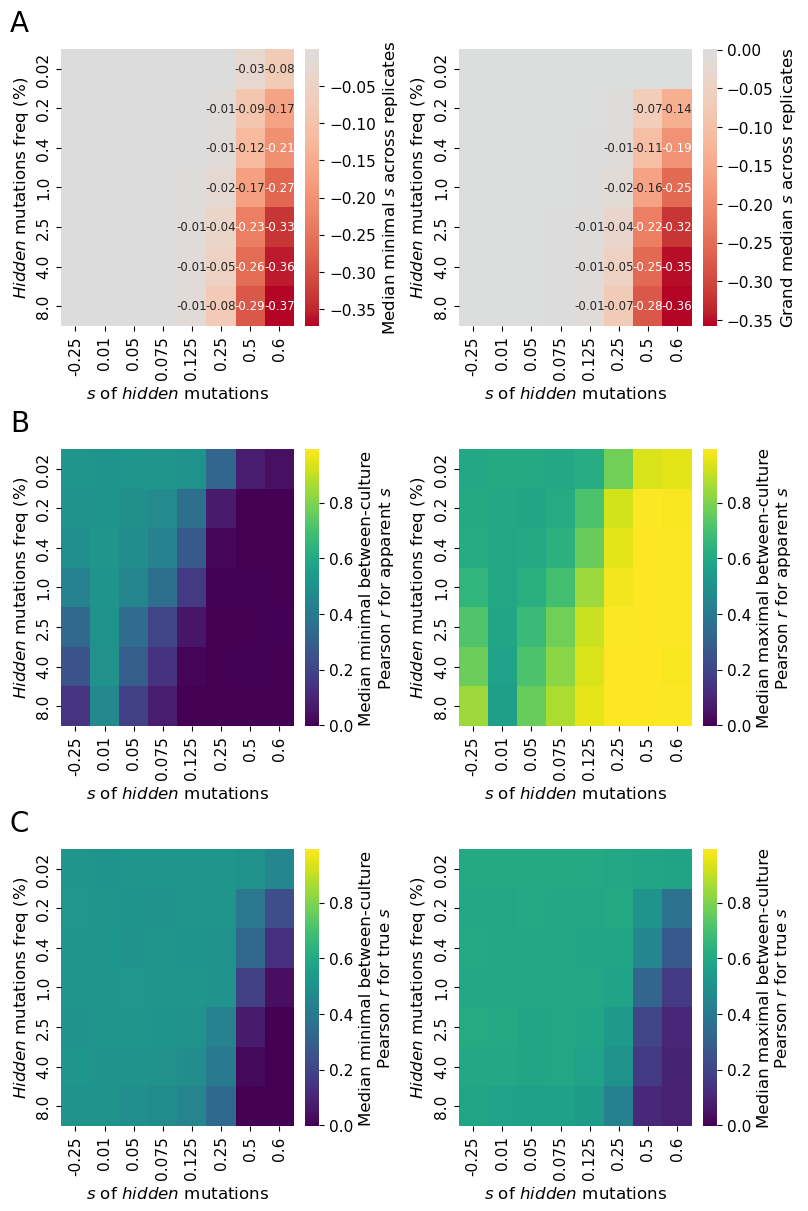

In [65]:
# Preparing the figure
fig, axs = plt.subplots(3, 2, figsize=(8, 12), constrained_layout=True)

annot_1 = np.where(min_app_muts.values <= -0.005, np.round(min_app_muts.values.astype('float64'), decimals=2).astype('str'), '')
sns.heatmap(min_app_muts.infer_objects(), ax=axs[0,0], cmap='coolwarm_r', center=0, annot=annot_1, annot_kws={'fontsize':8.5}, fmt='',
            cbar_kws={'label': r"Median minimal $s$ across replicates"})
annot_2 = np.where(med_app_muts.values <= -0.005, np.round(med_app_muts.values.astype('float64'), decimals=2).astype('str'), '')
sns.heatmap(med_app_muts.infer_objects(), ax=axs[0,1], cmap='coolwarm_r', center=0, annot=annot_2, annot_kws={'fontsize':8.5}, fmt='',
           cbar_kws={'label': r"Grand median $s$ across replicates"})

# For correlations
min_r_muts = min_r_muts.infer_objects()
max_r_muts = max_r_muts.infer_objects()
min_r_true = min_r_true.infer_objects()
max_r_true = max_r_true.infer_objects()

min_r = np.min([np.min(min_r_muts), np.min(max_r_muts), np.min(min_r_true), np.min(max_r_true)])
max_r = np.max([np.max(min_r_muts), np.max(max_r_muts), np.max(min_r_true), np.max(max_r_true)])
sns.heatmap(min_r_muts, ax=axs[1,0], cmap='viridis', vmin=min_r, vmax=max_r, cbar_kws={'label': r"Median minimal between-culture" '\n' r"Pearson $r$ for apparent $s$"})
sns.heatmap(max_r_muts, ax=axs[1,1], cmap='viridis', vmin=min_r, vmax=max_r, cbar_kws={'label': r"Median maximal between-culture" '\n' r"Pearson $r$ for apparent $s$"})

sns.heatmap(min_r_true, ax=axs[2,0], cmap='viridis', vmin=min_r, vmax=max_r, cbar_kws={'label': r"Median minimal between-culture" '\n' r"Pearson $r$ for true $s$"})
sns.heatmap(max_r_true, ax=axs[2,1], cmap='viridis', vmin=min_r, vmax=max_r, cbar_kws={'label': r"Median maximal between-culture" '\n' r"Pearson $r$ for true $s$"})

# Labeling the axes of each heatmap
for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1]]:
    ax.set_xlabel(r"$s$ of $\it{hidden}$ mutations")
    ax.set_ylabel(r"$\it{Hidden}$ mutations freq (%)")
    ax.tick_params(axis='x', labelrotation=90)

# Annotating the axes
axs[0,0].annotate('A', (-1.75, -0.45), fontsize=20, annotation_clip=False)
axs[1,0].annotate('B', (-1.75, -0.45), fontsize=20, annotation_clip=False)
axs[2,0].annotate('C', (-1.75, -0.45), fontsize=20, annotation_clip=False)

FigS6 = plt.gcf()
FigS6.savefig('Supp_figs/S6Fig.tiff', bbox_inches='tight')

When there is a high initial frequency of *hidden* mutations with very high s, the (very small) true selection coefficients are difficult to recover, due to the small population size of the variant pool of interest and to the resulting increased noise.